# Libraries

In [6]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')/kaggle/input/house-prices-advanced-regression-techniques/train.csv

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

from collections import Counter #for IQR method
from scipy.stats import median_abs_deviation #for modified z-score
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

from sklearn.feature_selection import f_regression, VarianceThreshold, SelectKBest, SelectPercentile, chi2, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score

# Helping functions

In [454]:
"""
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

from collections import Counter #for IQR method
from scipy.stats import median_abs_deviation #for modified z-score
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

from sklearn.feature_selection import f_regression, VarianceThreshold, SelectKBest, SelectPercentile, chi2, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
"""

#calculate adjusted r2
def m_adjusted_r2(obs_num, var_num,r2):
    return (1-(1-r2)*((obs_num-1)/(obs_num-var_num-1)))

#show features regression in Dataframe
def m_fregression(x,y):
    features_regression = pd.DataFrame(columns=['feature','coefficient','pval'])
    for i in range (x.shape[1]):
        df_f_regression = f_regression(x,y)
        row = {'feature':x.columns[i],'coefficient':df_f_regression[0][i].round(2),'pval':df_f_regression[1][i].round(5)}
        features_regression = features_regression.append(row,ignore_index=True)
    return (features_regression)

#calculating multicolinearity between variables
def m_VIF(x,y):
    #get columns names
    a = x.columns
    b = y.columns
    
    #loop to generate a (specially-formated) string containing (dependant variable) and (independent variables)
    string_fun = '{}~'.format(b[0])
    for i in range(0,len(a),1):
        string_fun = string_fun+"{}+".format(a[i])
        
    #to drop the last (+)
    string_fun= string_fun[0:len(string_fun)-1]
    string_fun
    
    #generate a full dataframe containing dependent and independent variables
    df_vif_gen = pd.merge(left=y,right=x,left_index=True,right_index=True)
    
    
    #find design matrix for regression model using 'rating' as response variable 
    y,x = dmatrices(string_fun, data=df_vif_gen, return_type='dataframe')

    #create DataFrame to hold VIF values
    vif_df = pd.DataFrame()
    vif_df['variable'] = x.columns 

    #calculate VIF for each predictor variable 
    vif_df['VIF'] = np.round([variance_inflation_factor(x.values, i) for i in range(x.shape[1])],2)

    #view VIF for each predictor variable 
    print ('VIF=1: There is no correlation between a given predictor variable and any other predictor variables in the model.\n')
    print ('VIF=(1-5): There is moderate correlation between a given predictor variable and other predictor variables in the model.\n')
    print ('VIF>5: There is severe correlation between a given predictor variable and other predictor variables in the model.')

    return vif_df

# find correlated features
def m_correlation(dataset, threshold):
    col_corr = []  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.append(colname)
    return col_corr

#reduce dataframe by quantile value (outlier), return the reduced dataframe and print the curve
def m_df_trim (dataframe,column_name,q_low,q_high):   
    q_low = dataframe[column_name].quantile(q=q_low)
    q_high = dataframe[column_name].quantile(q=q_high)

    df_reduced = dataframe[(dataframe[column_name]>q_low)&(dataframe[column_name]<=q_high)]
    print (np.round(100-df_reduced.shape[0]/dataframe.shape[0]*100,2),"% of data will be lost")
    fig, ax = plt.subplots(figsize=(15,5),nrows=1,ncols=2);
    sns.histplot(data=dataframe,x=column_name,ax=ax[0],label='Original');
    sns.histplot(data=df_reduced,x=column_name,ax=ax[1],label='Reduced')
    ax[0].legend()
    ax[1].legend()
    return df_reduced

#creating different linear regression models and a dataframe containing the summary info
def m_mlinear_regression(xtr,xts,ytr,yts):
#create a dataframe for modeling summary 
    models_summary = pd.DataFrame(columns=['Model','Type','Scaled','Score'])

    #multiple linear regression
    model = LinearRegression()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Linear'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    
    #support vector regression
    model_variables=['rbf','linear','poly','sigmoid']
    for i in model_variables:
        model = SVR(kernel=i)
        model.fit(xtr,ytr)
        ypr = model.predict(xts)
        #
        model_name='SVR'
        model_type=i
        scaled='No'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Decision treeregression
    model = DecisionTreeRegressor()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Decision tree'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Random forest regression
    model_variables = [100,200,300,400,500]
    for i in model_variables:
        model = RandomForestRegressor(n_estimators=i)
        model.fit(xtr,ytr)
        ypr = model.predict(xts)
        #
        model_name='Random forest'
        model_type=i
        scaled='No'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #XGBoost
    model = XGBRegressor()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='XGBoost'
    scaled='No'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    
#---------------SCALING-------------------#
    sc    = StandardScaler()              #
    xtr_sc= sc.fit_transform(xtr)         #
    xts_sc= sc.transform(xts)             #
#-----------------------------------------#
    #multiple linear regression
    model = LinearRegression()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Linear'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    
    #support vector regression
    model_variables=['rbf','linear','poly','sigmoid']
    for i in model_variables:
        model = SVR(kernel=i)
        model.fit(xtr_sc,ytr)
        ypr = model.predict(xts_sc)
        #
        model_name='SVR'
        model_type=i
        scaled='Yes'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Decision treeregression
    model = DecisionTreeRegressor()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Decision tree'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Random forest regression
    model_variables = [100,200,300,400,500]
    for i in model_variables:
        model = RandomForestRegressor(n_estimators=i)
        model.fit(xtr_sc,ytr)
        ypr = model.predict(xts_sc)
        #
        model_name='Random forest'
        model_type=i
        scaled='Yes'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #XGBoost
    model = XGBRegressor()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='XGBoost'
    scaled='Yes'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)


    model_summary = models_summary.sort_values(by='Score',ascending=False)
    model_summary.reset_index(inplace=True)
    return model_summary

#return a list and graph of how features importance to target value
def m_feature_importance (xtrain,ytrain,n_estimators):
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(xtrain,ytrain)
    df_features_importance = pd.DataFrame({'features':xtrain.columns,'importance':rf.feature_importances_})
    df_features_importance.sort_values(by='importance',axis=0,inplace=True,ascending=False)
    sns.barplot(x=df_features_importance['importance'],
                y=df_features_importance['features'],
                color='b')  
    return df_features_importance

#calculate adjusted r2
def m_adjusted_r2(obs_num, var_num,r2):
    return (1-(1-r2)*((obs_num-1)/(obs_num-var_num-1)))

#show features regression in Dataframe
def m_fregression(x,y):
    features_regression = pd.DataFrame(columns=['feature','coefficient','pval'])
    for i in range (x.shape[1]):
        df_f_regression = f_regression(x,y)
        row = {'feature':x.columns[i],'coefficient':df_f_regression[0][i].round(2),'pval':df_f_regression[1][i].round(5)}
        features_regression = features_regression.append(row,ignore_index=True)
    return (features_regression)

#calculating multicolinearity between variables
def m_VIF(x,y):
    #get columns names
    a = x.columns
    b = y.columns
    
    #loop to generate a (specially-formated) string containing (dependant variable) and (independent variables)
    string_fun = '{}~'.format(b[0])
    for i in range(0,len(a),1):
        string_fun = string_fun+"{}+".format(a[i])
        
    #to drop the last (+)
    string_fun= string_fun[0:len(string_fun)-1]
    string_fun
    
    #generate a full dataframe containing dependent and independent variables
    df_vif_gen = pd.merge(left=y,right=x,left_index=True,right_index=True)
    
    
    #find design matrix for regression model using 'rating' as response variable 
    y,x = dmatrices(string_fun, data=df_vif_gen, return_type='dataframe')

    #create DataFrame to hold VIF values
    vif_df = pd.DataFrame()
    vif_df['variable'] = x.columns 

    #calculate VIF for each predictor variable 
    vif_df['VIF'] = np.round([variance_inflation_factor(x.values, i) for i in range(x.shape[1])],2)

    #view VIF for each predictor variable 
    print ('VIF=1: There is no correlation between a given predictor variable and any other predictor variables in the model.\n')
    print ('VIF=(1-5): There is moderate correlation between a given predictor variable and other predictor variables in the model.\n')
    print ('VIF>5: There is severe correlation between a given predictor variable and other predictor variables in the model.')

    return vif_df

# find correlated features
def m_correlation(dataset, threshold):
    col_corr = []  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.append(colname)
                col_corr = list(set(col_corr))
    return col_corr

#list the features which have correlation of specific values against the rest of dataset features
def m_corr_list(df,min_up=0.6,min_down=-0.6):
    corr_mat=df.corr()
#loop through orrelation-matrix rows
    for x in corr_mat.index:
        #list for features having positive correlation against first feature
        corr_feat_up=[]
        #list for features having negative correlation against first feature
        corr_feat_down=[]
        
        #add features which have correlation in the specified limits
        for y in corr_mat.columns:
            if (corr_mat.loc[x,y]>=min_up) and (x!=y): #skip feature against same feature
                corr_feat_up.append(y)
            elif (corr_mat.loc[x,y]<=min_down) and (x!=y): #skip feature against same feature
                corr_feat_down.append(y)
        if len(corr_feat_up)!=0:
            print ('\033[1m'+x+'\033[0m'+' is positively correlated with {}'.format(corr_feat_up))
        if len(corr_feat_down)!=0:
            print ('\033[1m'+x+'\033[0m'+' is negatively correlated with {}'.format(corr_feat_down))
        if len(corr_feat_up)!=0 or len(corr_feat_down)!=0:
            print ('')           

#reduce dataframe by quantile value (outlier), return the reduced dataframe and print the curve
def m_df_trim (dataframe,column_name,q_low,q_high):   
    q_low = dataframe[column_name].quantile(q=q_low)
    q_high = dataframe[column_name].quantile(q=q_high)

    df_reduced = dataframe[(dataframe[column_name]>q_low)&(dataframe[column_name]<=q_high)]
    print (np.round(100-df_reduced.shape[0]/dataframe.shape[0]*100,2),"% of data will be lost")
    fig, ax = plt.subplots(figsize=(15,5),nrows=1,ncols=2);
    sns.histplot(data=dataframe,x=column_name,ax=ax[0],label='Original');
    sns.histplot(data=df_reduced,x=column_name,ax=ax[1],label='Reduced')
    ax[0].legend()
    ax[1].legend()
    return df_reduced

#creating different linear regression models and a dataframe containing the summary info
def m_mlinear_regression(xtr,xts,ytr,yts):
#create a dataframe for modeling summary 
    models_summary = pd.DataFrame(columns=['Model','Type','Scaled','Score'])

    #multiple linear regression
    model = LinearRegression()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Linear'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    
    #support vector regression
    model_variables=['rbf','linear','poly','sigmoid']
    for i in model_variables:
        model = SVR(kernel=i)
        model.fit(xtr,ytr)
        ypr = model.predict(xts)
        #
        model_name='SVR'
        model_type=i
        scaled='No'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Decision treeregression
    model = DecisionTreeRegressor()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Decision tree'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Random forest regression
    model_variables = [100,200,300,400,500]
    for i in model_variables:
        model = RandomForestRegressor(n_estimators=i)
        model.fit(xtr,ytr)
        ypr = model.predict(xts)
        #
        model_name='Random forest'
        model_type=i
        scaled='No'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #XGBoost
    model = XGBRegressor()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='XGBoost'
    scaled='No'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #GradientBoosting   
    model = GradientBoostingRegressor()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='GradientBoosting'
    scaled='No'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)
    
#---------------SCALING-------------------#
    sc    = StandardScaler()              #
    xtr_sc= sc.fit_transform(xtr)         #
    xts_sc= sc.transform(xts)             #
#-----------------------------------------#
    #multiple linear regression
    model = LinearRegression()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Linear'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    
    #support vector regression
    model_variables=['rbf','linear','poly','sigmoid']
    for i in model_variables:
        model = SVR(kernel=i)
        model.fit(xtr_sc,ytr)
        ypr = model.predict(xts_sc)
        #
        model_name='SVR'
        model_type=i
        scaled='Yes'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Decision treeregression
    model = DecisionTreeRegressor()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Decision tree'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Random forest regression
    model_variables = [100,200,300,400,500]
    for i in model_variables:
        model = RandomForestRegressor(n_estimators=i)
        model.fit(xtr_sc,ytr)
        ypr = model.predict(xts_sc)
        #
        model_name='Random forest'
        model_type=i
        scaled='Yes'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #XGBoost
    model = XGBRegressor()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='XGBoost'
    scaled='Yes'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #GradientBoosting   
    model = GradientBoostingRegressor()
    model.fit(xtr_sc,ytr)
    
    model_summary = models_summary.sort_values(by='Score',ascending=False)
    model_summary.reset_index(inplace=True)
    return model_summary

#return a list and graph of how features importance to target value
def m_feature_importance (xtrain,ytrain,n_estimators):
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(xtrain,ytrain)
    df_features_importance = pd.DataFrame({'features':xtrain.columns,'importance':rf.feature_importances_})
    df_features_importance.sort_values(by='importance',axis=0,inplace=True,ascending=False)
    sns.barplot(x=df_features_importance['importance'],
                y=df_features_importance['features'],
                color='b')  
    return df_features_importance

#split dataframe into target variable and features
def m_xy_split(df,target_column):
    col = (df.columns).drop(target_column)
    y = df[[target_column]]
    x = df[col]
    return x,y

#from collections import Counter #for IQR method
def m_outlier_iqr (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
                
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] < Q1 - outlier_step]
    df2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of outliers is:', df1.shape[0]+df2.shape[0])
    print('Total number of observations containing more than {} outliers is: {} '.format(n,len(multiple_outliers)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(multiple_outliers)/df.shape[0]*100,0)))
    
    return multiple_outliers

def m_outlier_std (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations 
    containing more than n outliers according to the standard deviation method.
    """
    outlier_indices = []
    
    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()
        
        # calculate the cutoff value
        cut_off = data_std * 3
        
        # Determining a list of indices of outliers for feature column        
        outlier_list_column = df[(df[column] < data_mean - cut_off) | (df[column] > data_mean + cut_off)].index
        
        # appending the found outlier indices for column to the list of outlier indices 
        outlier_indices.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > data_mean + cut_off]
    df2 = df[df[column] < data_mean - cut_off]
    print('Total number of outliers is:', df1.shape[0]+ df2.shape[0])
    print('Total number of observations containing more than {} outliers is: {} '.format(n,len(multiple_outliers)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(multiple_outliers)/df.shape[0]*100,0)))
    
    return multiple_outliers   

#from scipy.stats import median_abs_deviation #for modified z-score
def m_outlier_zscore (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations 
    containing more than n outliers according to the z-score method.
    """
    outlier_list = []
    
    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()
        threshold = 3
        
        z_score = abs( (df[column] - data_mean)/data_std )
        
        # Determining a list of indices of outliers for feature column        
        outlier_list_column =  df[z_score > threshold].index
        
        # appending the found outlier indices for column to the list of outlier indices 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of outlier records
    df1 = df[z_score > threshold]
    print('Total number of outliers is:', df1.shape[0])
    print('Total number of observations containing more than {} outliers is: {} '.format(n,len(multiple_outliers)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(multiple_outliers)/df.shape[0]*100,0)))
    
    return multiple_outliers

def m_outlier_zscore_modified (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations 
    containing more than n outliers according to the z-score modified method.
    """
    outlier_list = []
    
    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()
        threshold = 3
        MAD = median_abs_deviation
        
        mod_z_score = abs(0.6745*(df[column] - data_mean)/MAD(df[column]) )
                
        # Determining a list of indices of outliers for feature column        
        outlier_list_column =  df[mod_z_score >threshold].index
        
        # appending the found outlier indices for column to the list of outlier indices 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of outlier records
    df1 = df[mod_z_score >threshold]
    print('Total number of outliers is:', df1.shape[0])
    print('Total number of observations containing more than {} outliers is: {} '.format(n,len(multiple_outliers)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(multiple_outliers)/df.shape[0]*100,0)))
    
    return multiple_outliers

#from sklearn.ensemble import IsolationForest
def m_outlier_isolationforest(df,features=[]):
    df=df[features]
    outlier_model = IsolationForest()
    outlier_model.fit(df)
    anomaly = outlier_model.predict(df)
    df['anomaly'] = anomaly
    print ('The total number of outliers is: ',df[(df['anomaly']==-1)]['anomaly'].count())
    print('Percentage of data to be lost is: %{}'.format(np.round(df[(df['anomaly']==-1)]['anomaly'].count()/df.shape[0]*100,0)))

    return df

#from sklearn.cluster import DBSCAN
def m_outlier_DBSCAN(df,features=[]):
    df=df[features]
    sc = StandardScaler()
    df_sc = sc.fit_transform(df)
    model_DBSCAN = DBSCAN()
    model_DBSCAN.fit(df_sc)
    labels = model_DBSCAN.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    labels = pd.Series(labels)
    print ('The total number of clusters without outliers: ',n_clusters)
    print ('The number of outliers is: ',labels[(labels==-1)].count())
    print('Percentage of data to be lost is: %{}'.format(np.round(labels[(labels==-1)].count()/df.shape[0]*100,0)))           
    df['label']=labels
    return df

#perfrom all outliers detection methods
def m_outlier_all (df,n,features=[]):
    
    print ("Method IQR:")
    out_iqr = m_outlier_iqr(df,n=n,features=features)
    print ("\nMethod Standard deviation:")
    out_std = m_outlier_std(df,n=n,features=features)
    print ("\nMethod Z-Score:")
    out_zsc = m_outlier_zscore(df,n=n,features=features)
    print ("\nMethod Modified Z-Score:")
    out_mzs = m_outlier_zscore_modified(df,n=n,features=features)
    print ("\nMethod Isolation forest:")
    df_isf = m_outlier_isolationforest(df,features=features)
    out_isf = list(df_isf[(df_isf['anomaly']==-1)].index)
    print ("\nMethod DBSCAN:")
    df_dbscan = m_outlier_DBSCAN(df,features=features)
    out_dbs = list(df_dbscan[(df_dbscan['label']==-1)].index)
    
    out_total = set(out_iqr).intersection(out_std,out_zsc,out_mzs,out_dbs,out_isf)
    print (100*'-')
    print('Total number of outliers is: {} '.format(len(out_total)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(out_total)/df.shape[0]*100,0)))
    
    return out_total

class m_describe:
    def __init__(self,dataframe):
        self.dataframe=df

    def show_main (df,export_notes=False):
        df=df
        print ("Total number of features: ", len(df.columns))
        print ("Total number of observations: ", len(df))
        print ('-'*70)
        print ('Total number of numerical values: ',len(list(df.select_dtypes(include=['int64', 'float64']).columns)))
        print ('Total number of categorical values: ',len(list(df.select_dtypes(include=['object']).columns)))
        print ('-'*70)
        print ("Total number of missing values: ", df.isnull().sum().sum())
        print ("Total number of duplicate rows: ", df.duplicated().sum())
        plt.pie(x=[len(list(df.select_dtypes(include=['int64', 'float64']).columns)),
                   len(list(df.select_dtypes(include=['object']).columns))],
               labels=['Numerical Features','Categorical Features'],autopct='%1.0f%%')
        plt.title('Features Types')
             
        #export features_notes 
        if export_notes==True:
            x= list(df.select_dtypes(include=['object']).columns) #get list of numerical features
            cat_df = pd.DataFrame(x, columns=['Feature']) #create dataframe containg numerical features
            cat_df['Type']='Categorical'

            y= list(df.select_dtypes(include=['int64', 'float64']).columns) #get list of categorical features
            num_df = pd.DataFrame(y, columns=['Feature']) #create dataframe containing categorical features
            num_df['Type']='Numerical'

            fea_df = pd.concat([num_df, cat_df]) #merge above dataframes
            fea_df[['Description','Importance','Observation','To Do']]=""
            fea_df.to_excel('notes.xlsx',index=False)
            del x,y,fea_df

    
    #returns a list of numerical values
    def num(df):
        df=df
        return list(df.select_dtypes(include=['int64', 'float64']).columns)
    #returns a list of categorical values
    def cat(df):
        df=df
        return list(df.select_dtypes(include=['object']).columns)
    
    #returns a list of missing values sorted from high to low and categorized by features 
    def missing_val_list(df):
        df=df
        x= list(df.select_dtypes(include=['object']).columns) #get list of numerical features
        cat_df = pd.DataFrame(x, columns=['Feature']) #create dataframe containg numerical features
        cat_df['Type']='Categorical'

        y= list(df.select_dtypes(include=['int64', 'float64']).columns) #get list of categorical features
        num_df = pd.DataFrame(y, columns=['Feature']) #create dataframe containing categorical features
        num_df['Type']='Numerical'

        fea_df = pd.concat([num_df, cat_df]) #merge above dataframes

        x= list(df.columns) #get list of all features
        y= list(np.round(df.isnull().sum()/len(df)*100,0)) #get % of null values of all features
        z= list((df.isnull().sum())) #get sum of null values of all features
        nul_df = pd.DataFrame({'Feature':x,'count of nulls':z,'null % of total obesrvations':y}) #create dataframe from x,y,z

        nul_df = pd.merge(fea_df,nul_df,on='Feature',how='outer') #merge all dataframes
        nul_df=nul_df[(nul_df['count of nulls']>0)] #show only features having null values
        nul_df.sort_values(by=['Type','null % of total obesrvations'],ascending=False) #sorting
        nul_df=nul_df.reset_index(drop=True) #drop index
        del x,y,z,cat_df,num_df #delete all temporary variables
        return nul_df 
    
    #visualize numerical feauters
    def visualize_num(df,
                      features='all',
                     figure_size=(15,150),color=sns.color_palette('Set2')[0]):
        df=df
        if features == 'all':
            features=list(df.select_dtypes(include=['int64', 'float64']).columns)
        fig, a=plt.subplots(nrows=len(features),ncols=2,figsize=figure_size)
        for i in range(len(features)):
            sns.histplot(data=df[features[i]],color=color,ax=a[i,0])
            sns.boxplot(y=df[features[i]],color=color,ax=a[i,1])
        del features
        #return fig
        
    #visualize categorical features
    def visualize_cat(df,
                      features='all',
                      figure_size=(15,150), color_scheme='Set2'):
        df=df
        if features == 'all':
            features=list(df.select_dtypes(include=['object']).columns)
        fig, a=plt.subplots(nrows=len(features),ncols=2,figsize=figure_size)
        for i in range (len(features)):
            sorted_labels=df[features[i]].value_counts().sort_values(ascending=False).index
            sns.countplot(df[features[i]],palette=color_scheme,order=sorted_labels,ax=a[i,0])
            a[i,1].pie(df[features[i]].value_counts(),labels=list(sorted_labels),autopct='%1.0f%%',colors=sns.color_palette(sns.color_palette(color_scheme)));
        del features, sorted_labels
        #return fig
    
    #show first 
    def show_category_concentraction(df,min_percent=0.95):
        #create auxilary dataframe
        x=pd.DataFrame(df.nunique(),columns=['Unique values'])
        x=x.reset_index()
        #add new column -feature
        x=x.rename(columns={'index':'Feature'})
        x= x.sort_values(by='Unique values',ascending=True)

        #get list of features
        list_of_features=list(x['Feature'].unique())
        #loop through all feature and get percentage of data in the top category
        for i in range(len(list_of_features)):
            feature=list_of_features[i]
            n_unique = df[feature].nunique()
            value_counts = df[feature].value_counts()
            percentage=np.round(value_counts.max() / value_counts.sum()*100)
            x.loc[x['Feature']==feature, '1st category concentration -%'] = percentage
        x=x[x['1st category concentration -%']/100>=min_percent]
        x = x.sort_values(by=['Unique values','1st category concentration -%'],ascending=[True,False])
        x=x.reset_index(drop=True)
        return x
 
def m_scale_encode_split(dftrain,target_feature,num_feature,cat_feature,train_size=0.85,dftest=None):
    #separating target variable and features
    df=dftrain
    y_ml=df[target_feature]
    x_ml=df[num_feature+cat_feature]

    #Encoding categorical features
    x_ml_dum = pd.get_dummies(x_ml,columns=cat_feature,drop_first=True)

    #splitting data
    xtr,xts,ytr,yts=train_test_split(x_ml_dum,y_ml,train_size=train_size)

    #Scaling numerical features
    xtr_sc=xtr.copy()
    xts_sc=xts.copy()
    sc=StandardScaler()
    xtr_sc[num_feature]=sc.fit_transform(xtr[num_feature])
    xts_sc[num_feature]=sc.transform(xts[num_feature])
    
    
    if dftest is None:
        return xtr_sc,xts_sc,ytr,yts
    else:
        dfts=dftest[num_feature+cat_feature]
        dfts_dum = pd.get_dummies(dfts,columns=cat_feature,drop_first=True)
        dfts_sc=dfts_dum.copy()
        dfts_sc[num_feature]=sc.transform(dfts_sc[num_feature])
        
        return xtr_sc,xts_sc,ytr,yts,dfts_sc

# Importing data

In [8]:
df_raw = pd.read_csv('train.csv')

In [9]:
df_raw.head(5)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

## Exploratory Data Analysis

In [10]:
df_raw.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

Total number of features:  81
Total number of observations:  1460
----------------------------------------------------------------------
Total number of numerical values:  38
Total number of categorical values:  43
----------------------------------------------------------------------
Total number of missing values:  6965
Total number of duplicate rows:  0


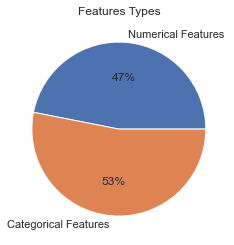

In [11]:
m_describe.show_main(df_raw)

By examining features, we want to know how the following features can affect the sale price of property: 
- Property type / Area / lot shape / building type / house style
- Year built / remodeled
- overall quality / condition
- Surrounding area (street / location in city / 
- Masonry type
- Basement (type / area)
- number of floors / area
- bathrooms (number / 
- Bedroom (number / area / quality)
- Kitchen (number / area / quality)
- Garage (year built / area)
- Roof (style / condition)
- Others: 
    * Fire places
    * Utilities
    * Exterior
    * Interior
    * Heating / AC
 
Also, we want to build a pricing model based on above features

## Investigating missing values

In [12]:
m_describe.missing_val_list(df_raw)

Feature         Type  count of nulls  null % of total obesrvations
0    LotFrontage    Numerical             259                          18.0
1     MasVnrArea    Numerical               8                           1.0
2    GarageYrBlt    Numerical              81                           6.0
3          Alley  Categorical            1369                          94.0
4     MasVnrType  Categorical               8                           1.0
5       BsmtQual  Categorical              37                           3.0
6       BsmtCond  Categorical              37                           3.0
7   BsmtExposure  Categorical              38                           3.0
8   BsmtFinType1  Categorical              37                           3.0
9   BsmtFinType2  Categorical              38                           3.0
10    Electrical  Categorical               1                           0.0
11   FireplaceQu  Categorical             690                          47.0
12    GarageType  Categorical              81                           6.0
13  GarageFinish  Categorical              81                           6.0
14    GarageQual  Categorical              81                           6.0
15    GarageCond  Categorical              81                           6.0
16        PoolQC  Categorical            1453                         100.0
17         Fence  Categorical            1179                          81.0
18   MiscFeature  Categorical            1406                          96.0

* Numerical features [LotFrontage,MasVnrArea,GarageYrBlt],  don't have a big percentage of null values so nothing to do till we check their distribution
* Categorical features [Alley,FireplaceQu,PoolQC,Fence,MiscFeature], they have a large % of missing values, so I'll drop those features because they'll not have a noticeable impact on our data

In [13]:
df1 = df_raw.copy()

In [14]:
df1.drop(labels=['Alley','FireplaceQu','PoolQC','Fence','MiscFeature'],axis=1,inplace=True)

Total number of features:  76
Total number of observations:  1460
----------------------------------------------------------------------
Total number of numerical values:  38
Total number of categorical values:  38
----------------------------------------------------------------------
Total number of missing values:  868
Total number of duplicate rows:  0


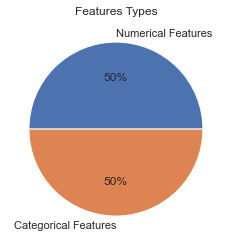

In [15]:
m_describe.show_main(df1)

Let's examine categorical variables to figure what to do with missing values

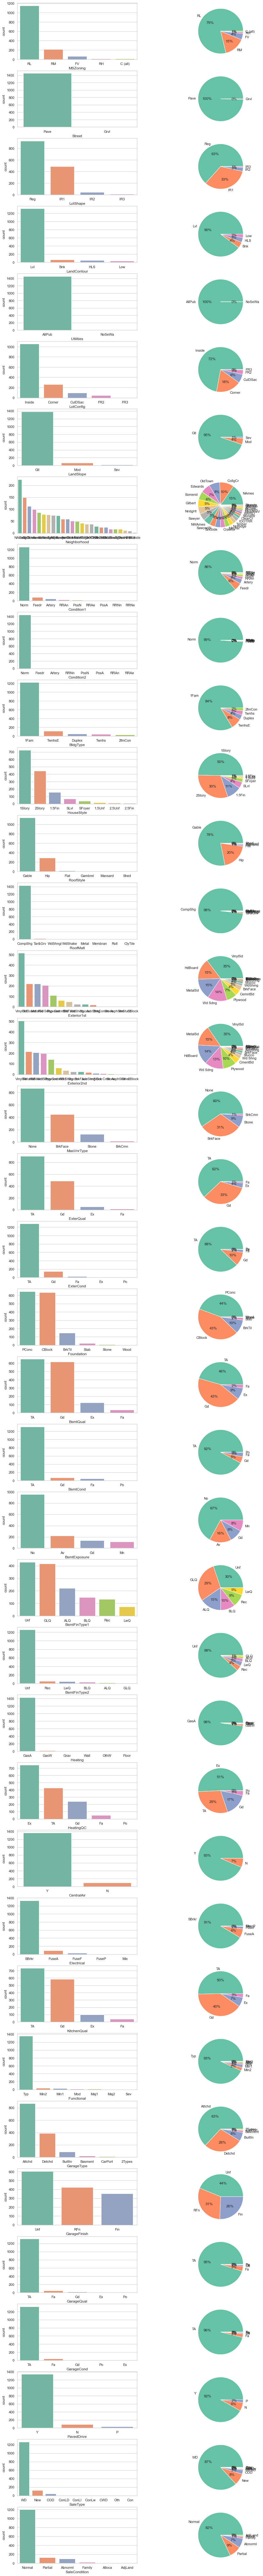

In [16]:
m_describe.visualize_cat(df1)

observations in features ['Street','Utilities','Condition2','RoofMatl'] are concentrated in one category so they don't add new information to our data so I'll delete them

In [17]:
df2 = df1.copy()
df2.drop(labels=['Street','Utilities','Condition2','RoofMatl'],axis=1,inplace=True)

What about exploring numerical features

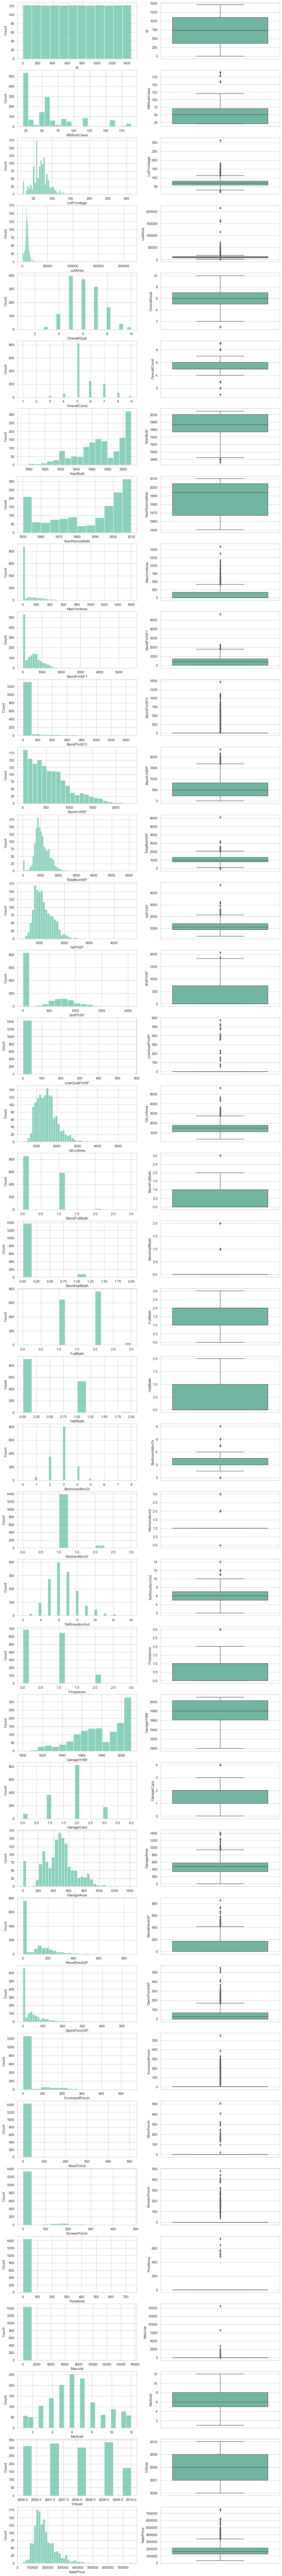

In [18]:
#Exploring numerical features
m_describe.visualize_num(df2)

Based on basic exploration of numerical features: 
* ['Id'] is unique and doesn't add any value to dataset
* [LowQualFinSF,BsmtHalfBath,KitchenAbvGr,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,]: all observations are concentrated on one value so these features don't add any value to dataset.

So, I will delete the above features

In [19]:
df3 = df2.copy()
labels=['Id','LowQualFinSF','BsmtHalfBath','KitchenAbvGr','EnclosedPorch','3SsnPorch',
        'ScreenPorch','PoolArea','MiscVal','YrSold']
df3.drop(labels=labels,axis=1,inplace=True)

* By exploring the distribution of the above features, I think the following features shall be considered categorical and not numerical: 

['MSSubClass','OverallQual','OverallCond','BsmtFullBath','FullBath','HalfBath','BedroomAbvGr','Fireplaces','GarageCars']

In [20]:
list_num= m_describe.num(df3)
list_cat= m_describe.cat(df3)

In [21]:
len(list_num)

28

In [22]:
len(list_cat)

34

In [23]:
cat_list=['MSSubClass','OverallQual','OverallCond','BsmtFullBath','FullBath','HalfBath','BedroomAbvGr','Fireplaces','GarageCars']
for cat in range(len(cat_list)):
    list_num.remove(cat_list[cat])
    list_cat.append(cat_list[cat])  
   

In [24]:
len(list_num)

19

In [25]:
len(list_cat)

43

So in our reduced dataset, we have total 62 features (19 numerical and 43 categorical)

# Handling missing values

In [26]:
m_describe.missing_val_list(df3)

Feature         Type  count of nulls  null % of total obesrvations
0    LotFrontage    Numerical             259                          18.0
1     MasVnrArea    Numerical               8                           1.0
2    GarageYrBlt    Numerical              81                           6.0
3     MasVnrType  Categorical               8                           1.0
4       BsmtQual  Categorical              37                           3.0
5       BsmtCond  Categorical              37                           3.0
6   BsmtExposure  Categorical              38                           3.0
7   BsmtFinType1  Categorical              37                           3.0
8   BsmtFinType2  Categorical              38                           3.0
9     Electrical  Categorical               1                           0.0
10    GarageType  Categorical              81                           6.0
11  GarageFinish  Categorical              81                           6.0
12    GarageQual  Categorical              81                           6.0
13    GarageCond  Categorical              81                           6.0

## Numerical Features

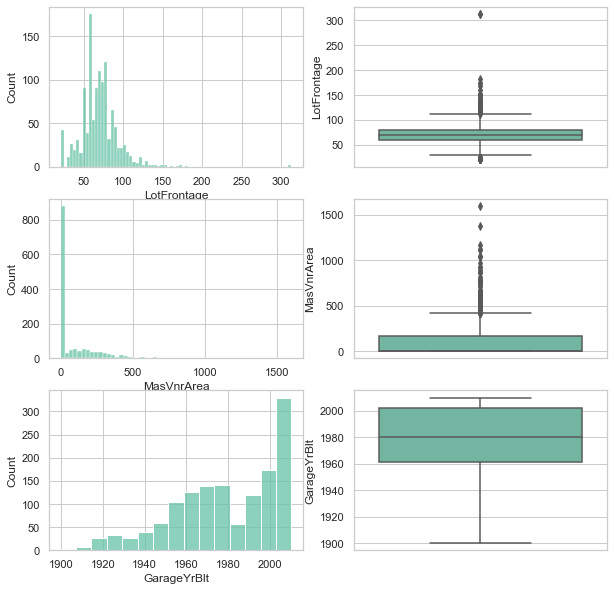

In [27]:
m_describe.visualize_num(df3,features=['LotFrontage','MasVnrArea','GarageYrBlt'],figure_size=(10,10))

In [28]:
#LotFrontage
# it's a normal distribution with outliers, so i'll fill missing values with median

df4 = df3.copy()
df4['LotFrontage'].fillna(df4['LotFrontage'].median(),inplace=True)

In [29]:
#GarageYrBlt
# I Think there is not a correct or wrong technique for filling missing values in such feature, So i will choose the medean method
df5=df4.copy()
df5['GarageYrBlt'].fillna(df5['GarageYrBlt'].median(),inplace=True)

In [31]:
#MasVnrArea
df3['MasVnrArea'].value_counts()[0]/df3['MasVnrArea'].value_counts().sum()*100

59.29752066115702

I will fill missing values with most frequently used observation

In [32]:
df6=df5.copy()
df6['MasVnrArea'].fillna(df6['MasVnrArea'].mode()[0],inplace=True)

In [33]:
df6['MasVnrArea'].isnull().sum()

0

## Categorical Features

In [34]:
m_describe.missing_val_list(df6)

Feature         Type  count of nulls  null % of total obesrvations
0     MasVnrType  Categorical               8                           1.0
1       BsmtQual  Categorical              37                           3.0
2       BsmtCond  Categorical              37                           3.0
3   BsmtExposure  Categorical              38                           3.0
4   BsmtFinType1  Categorical              37                           3.0
5   BsmtFinType2  Categorical              38                           3.0
6     Electrical  Categorical               1                           0.0
7     GarageType  Categorical              81                           6.0
8   GarageFinish  Categorical              81                           6.0
9     GarageQual  Categorical              81                           6.0
10    GarageCond  Categorical              81                           6.0

In [35]:
# I'll fill all missing values with mode
df7 = df6.copy()
df7.fillna(df7.mode().iloc[0],inplace=True)

# Handling Outliers

There are many techniques to detect and handle outliers, I've created a code that runs 6 different outlier detection techniques and get a list of outliers which is confirmed by all these methods.

In [36]:
drop_list= m_outlier_all(df7,n=0,features=list_num)

Method IQR:
Total number of outliers is: 61
Total number of observations containing more than 0 outliers is: 527 
Percentage of data to be lost is: %36.0

Method Standard deviation:
Total number of outliers is: 22
Total number of observations containing more than 0 outliers is: 179 
Percentage of data to be lost is: %12.0

Method Z-Score:
Total number of outliers is: 22
Total number of observations containing more than 0 outliers is: 179 
Percentage of data to be lost is: %12.0

Method Modified Z-Score:
Total number of outliers is: 56
Total number of observations containing more than 0 outliers is: 1460 
Percentage of data to be lost is: %100.0

Method Isolation forest:
The total number of outliers is:  118
Percentage of data to be lost is: %8.0

Method DBSCAN:
The total number of clusters without outliers:  0
The number of outliers is:  1460
Percentage of data to be lost is: %100.0
----------------------------------------------------------------------------------------------------
Tot

In [37]:
df8=df7.copy()

In [38]:
df8.drop(labels=drop_list,axis=0,inplace=True)

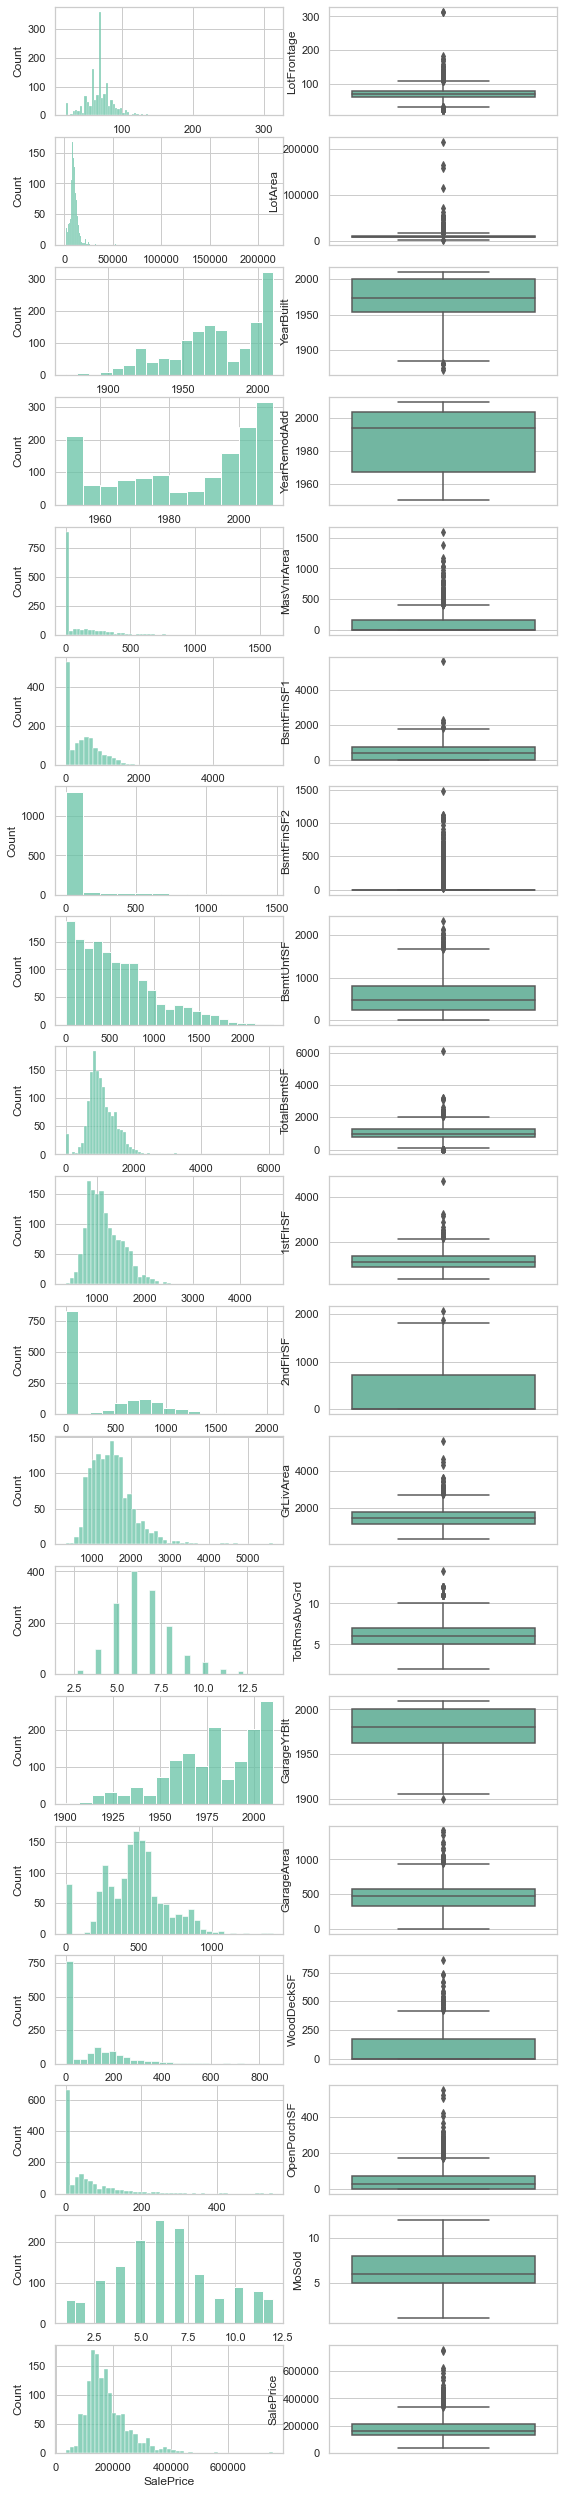

In [39]:
m_describe.visualize_num(df7,features=list_num,figure_size=(9,45))

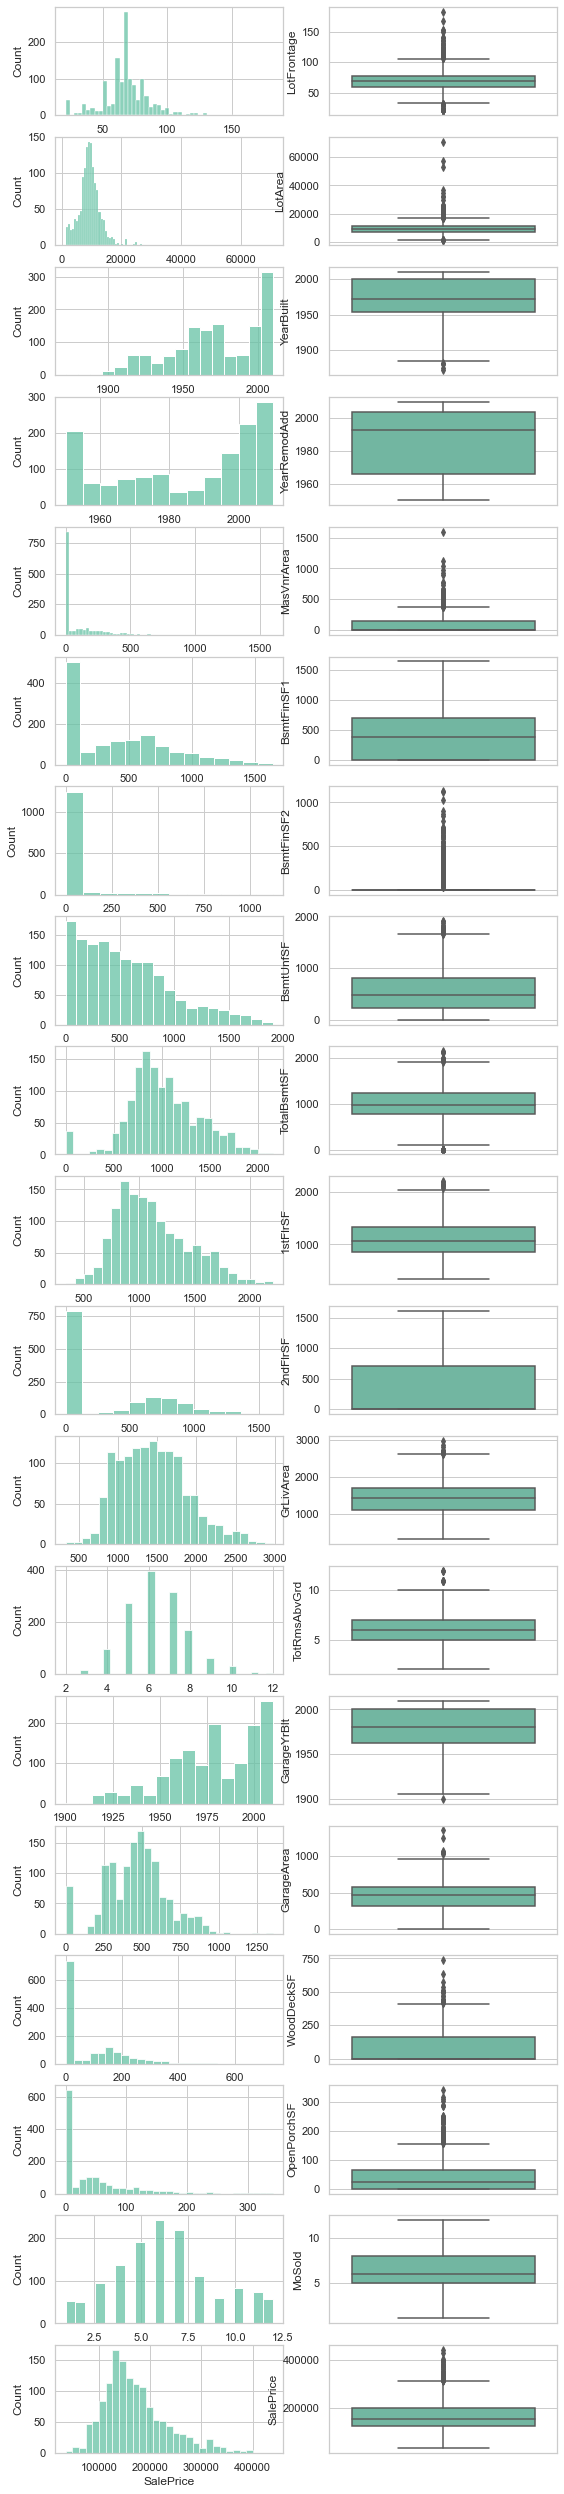

In [40]:
m_describe.visualize_num(df8,features=list_num,figure_size=(9,45))

I think that [LotArea] still has some outliers, I'll handle them again

In [41]:
drop_list = m_outlier_std(df8,features=['LotArea'],n=0)

Total number of outliers is: 17
Total number of observations containing more than 0 outliers is: 17 
Percentage of data to be lost is: %1.0


In [42]:
df9 = df8.copy()
df9.drop(labels=drop_list,axis=0,inplace=True)

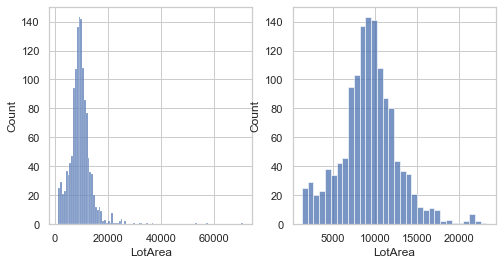

In [43]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
sns.histplot(df8['LotArea'],ax=ax[0]);
sns.histplot(df9['LotArea'],ax=ax[1]);

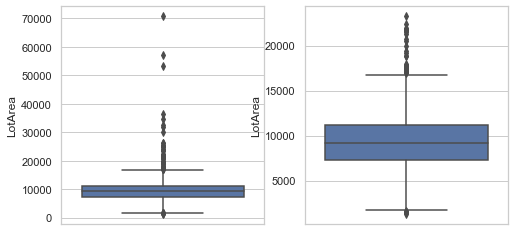

In [44]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
sns.boxplot(y= df8['LotArea'],ax=ax[0]);
sns.boxplot(y= df9['LotArea'],ax=ax[1]);

Let's check how much of data we lost after we completed out preprocessing stage

In [45]:
df9.shape[0]/df_raw.shape[0]*100

92.46575342465754

we lost 8% of data

# Data Analysis

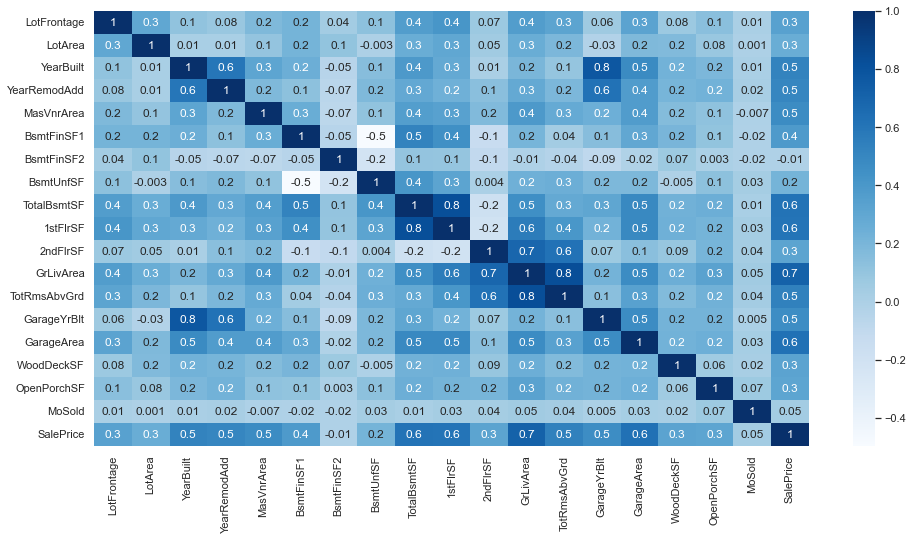

In [47]:
# let's check heat map between numerical features
fig,ax= plt.subplots(1,1,figsize=(16,8))
sns.heatmap(data=df7[list_num].corr(),ax=ax,cmap='Blues',annot=True,fmt='.1g');

Too many variables to inspect, let's filter features which have high correlation

In [48]:
m_corr_list(df9[list_num],0.6,-0.6)

YearBuilt is positively correlated with ['YearRemodAdd', 'GarageYrBlt', 'SalePrice']

YearRemodAdd is positively correlated with ['YearBuilt', 'GarageYrBlt']

TotalBsmtSF is positively correlated with ['1stFlrSF', 'SalePrice']

1stFlrSF is positively correlated with ['TotalBsmtSF']

2ndFlrSF is positively correlated with ['GrLivArea']

GrLivArea is positively correlated with ['2ndFlrSF', 'TotRmsAbvGrd', 'SalePrice']

TotRmsAbvGrd is positively correlated with ['GrLivArea']

GarageYrBlt is positively correlated with ['YearBuilt', 'YearRemodAdd']

GarageArea is positively correlated with ['SalePrice']

SalePrice is positively correlated with ['YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'GarageArea']



Let's check correlation between above variables

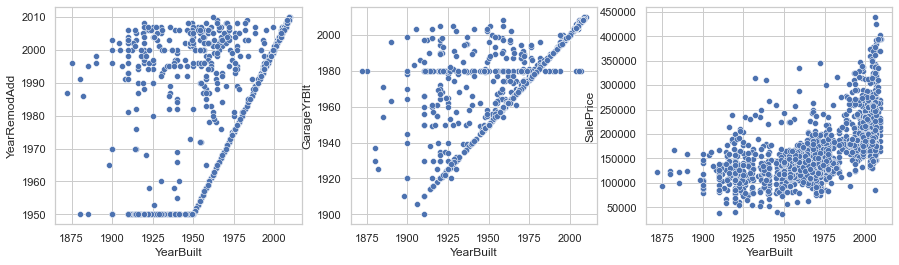

In [49]:
#YearBuilt
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,4))
sns.scatterplot(data=df9,x='YearBuilt',y='YearRemodAdd',ax=ax[0])
sns.scatterplot(data=df9,x='YearBuilt',y='GarageYrBlt',ax=ax[1])
sns.scatterplot(data=df9,x='YearBuilt',y='SalePrice',ax=ax[2]);

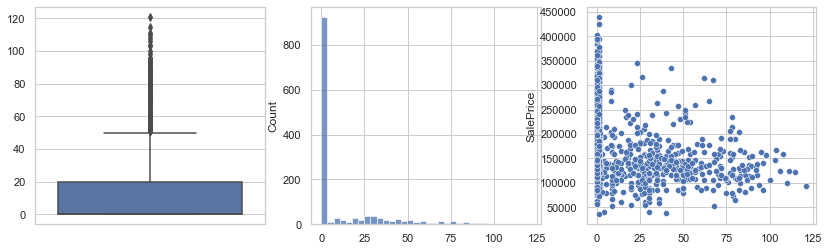

In [50]:
#Let's check after how many years, do people remodel their properties and it's effect of sale price
fig,ax=plt.subplots(1,3,figsize=(14,4))
maintenance_period = df9['YearRemodAdd']-df9['YearBuilt']
sns.boxplot(y=maintenance_period,ax=ax[0]);
sns.histplot(maintenance_period,ax=ax[1]);
sns.scatterplot(x=maintenance_period,y=df9['SalePrice'],ax=ax[2]);

In [51]:
maintenance_period.value_counts()

0      717
1      189
30      19
9       14
2       13
      ... 
94       1
56       1
108      1
111      1
84       1
Length: 104, dtype: int64

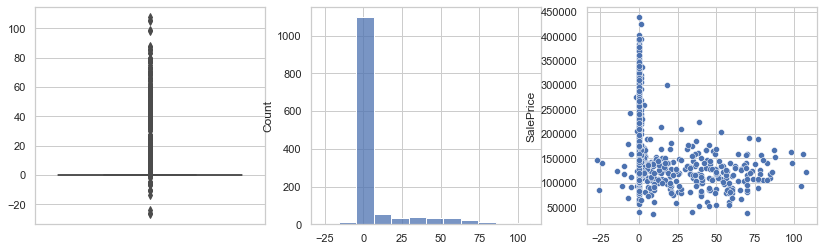

In [52]:
#Let's when Garage are built
fig,ax=plt.subplots(1,3,figsize=(14,4))
garage_period = df9['GarageYrBlt']-df9['YearBuilt']
sns.boxplot(y=garage_period,ax=ax[0]);
sns.histplot(garage_period,ax=ax[1]);
sns.scatterplot(x=garage_period,y=df9['SalePrice'],ax=ax[2]);

In [53]:
x = pd.DataFrame(garage_period.value_counts()).reset_index()
x[(x['index']<0)][0].sum()

17

* There is a positive correlation with high width between YearBuilt and SalePrice

* In 53% of data, YearBuilt and YearRemodAdd are the same which is not logic, may be it’s used to describe the last time the property was built/renewed

* In 60% of data, GarageYearBlt is the same as property yearbuilt which is logic. However, there are 17 observations where garage was built before propertty!

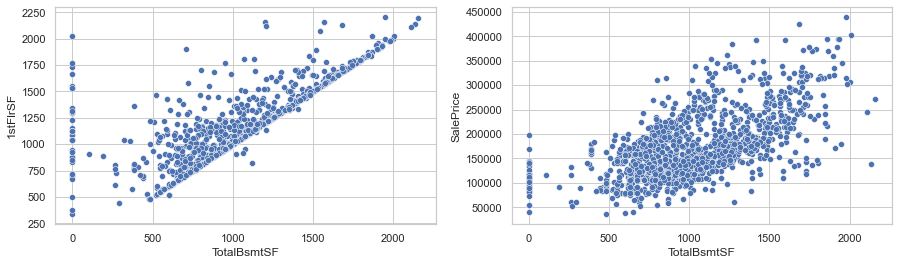

In [54]:
#TotalBsmtSF 
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,4))
sns.scatterplot(data=df9,x='TotalBsmtSF',y='1stFlrSF',ax=ax[0])
sns.scatterplot(data=df9,x='TotalBsmtSF',y='SalePrice',ax=ax[1]);

* There is a noticeable positive correlation between TotalBsmtSF and 1stFlrSF and SalePrice

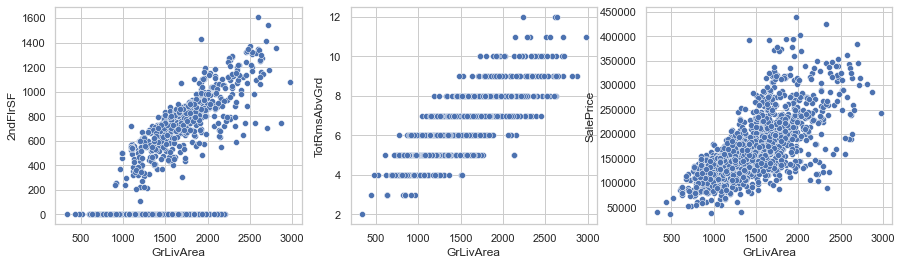

In [55]:
#GrLivArea 
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,4))
sns.scatterplot(data=df9,x='GrLivArea',y='2ndFlrSF',ax=ax[0])
sns.scatterplot(data=df9,x='GrLivArea',y='TotRmsAbvGrd',ax=ax[1])
sns.scatterplot(data=df9,x='GrLivArea',y='SalePrice',ax=ax[2]);

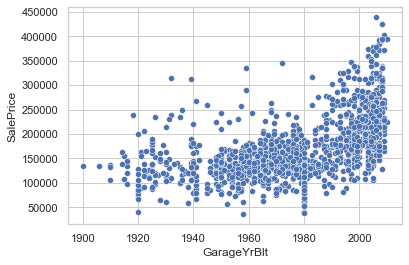

In [56]:
sns.scatterplot(df9['GarageYrBlt'],df9['SalePrice']);

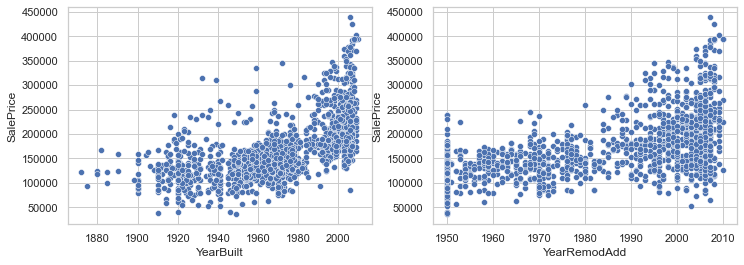

In [57]:
fig,a=plt.subplots(1,2,figsize=(12,4))
sns.scatterplot(df9['YearBuilt'],df9['SalePrice'],ax=a[0]);
sns.scatterplot(df9['YearRemodAdd'],df9['SalePrice'],ax=a[1]);

I think YearRemodAdd will be more representative for SalePrice than YearBuilt
I will drop the following columns: YearBuilt / GarageYrBlt since they don't add any new value to our dataset

In [58]:
df10=df9.copy()
df10.drop(labels=['YearBuilt','GarageYrBlt'],axis=1,inplace=True)

## Questions which my help to get insights from our dataset
1-	Does property type [MSSubClass] have an effect on [SalePrice]?
<br>2-	Relationship between MSZoning and SalePrice
<br>3-	Relationship between Neighborhood, MSSubClass, MSZoning and SalePrice
<br>4-	Relationship between LotArea, LotFrontage and SalePrice
<br>5-	Relationship between OverallQual and OverallCond
<br>6-	Relationship between OverallQual and OverallCond and YearBuilt and YearRemodAdd
<br>7-	When do they Remod the property
<br>8-	Relationship between YearBuilt / YearRemodAdd and SalePrice
<br>9-	Relationship between BsmtFinSF1 and BsntFinSF2 and BsmtUnfSF and TotalBsmtSF, 
<br>10-	Is there any relation between Bsmt and LotArea or SalePrice
<br>11-	Do SalePrice affected by month sold over the years
<br>12-	Does Condition1 affect any feature?
<br>13-	RoofStyle and LotArea or Saleprice
<br>14-	SaleType and SaleCondition
<br>15-	Does Utilities like: Heating, HeatingQC, CentrailAir, Electrical affect SalePrice, SaleType?
<br>16-	Can we combine the above utilities feature into a new one?

### Q1

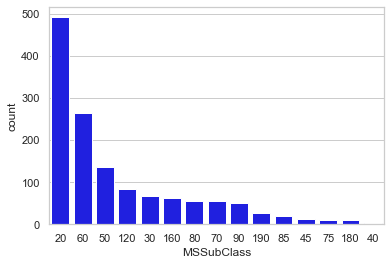

In [59]:
sns.countplot(df9['MSSubClass'],order=df9['MSSubClass'].value_counts().index,color='Blue');

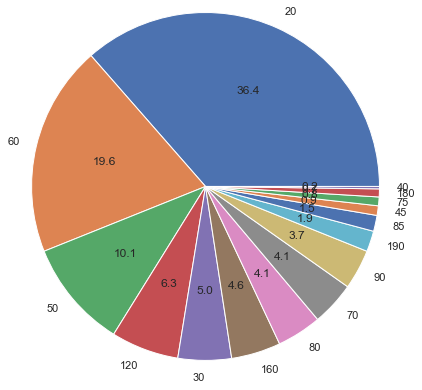

In [60]:
plt.pie(df9['MSSubClass'].value_counts(),labels=df9['MSSubClass'].value_counts().index,radius=2,autopct='%0.1f');

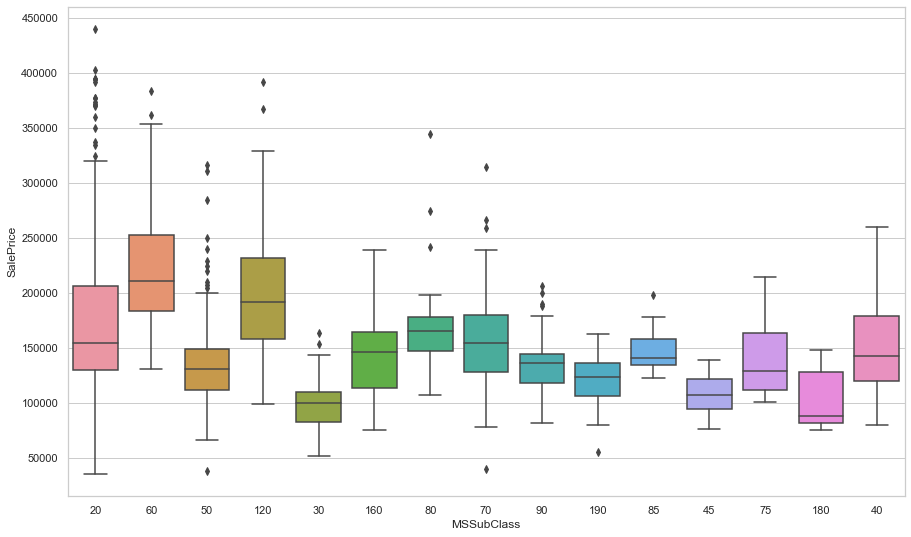

In [111]:
fig,ax=plt.subplots(1,1,figsize=(15,9))
sns.boxplot(data=df9,y='SalePrice',x='MSSubClass',ax=ax,order=df9['MSSubClass'].value_counts().index);

**Answer**<br>
•	50% of observation are in category 20 and 60, and they contain most of outliers <br>
•	All categories share the same range of SalePrice


### Q2

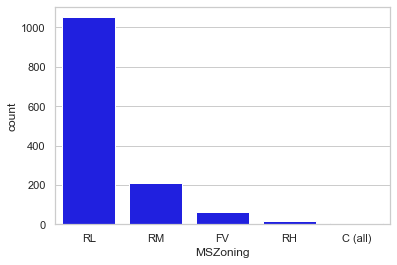

In [61]:
sns.countplot(df9['MSZoning'],order=df9['MSZoning'].value_counts().index,color='Blue');

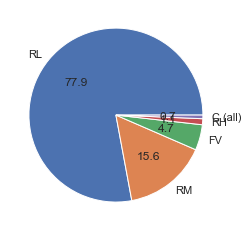

In [62]:
plt.pie(df9['MSZoning'].value_counts(),labels=df9['MSZoning'].value_counts().index,radius=1,autopct='%0.1f');

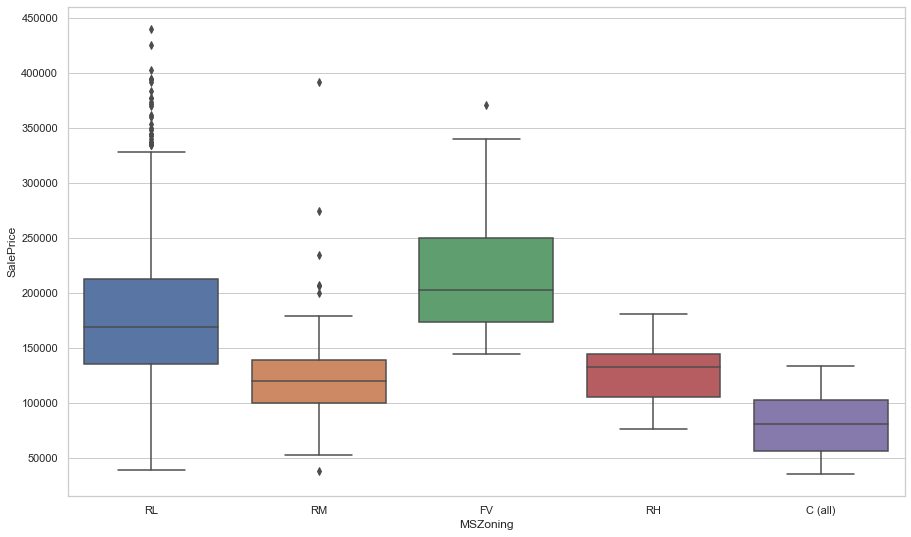

In [63]:
fig,ax=plt.subplots(1,1,figsize=(15,9))
sns.boxplot(data=df9,y='SalePrice',x='MSZoning',ax=ax,order=df9['MSZoning'].value_counts().index);

**Answer**<br>
•	93% of observation are on 2 categories RL and RM <br>
•	All categories share the same range of SalePrice


### Q3

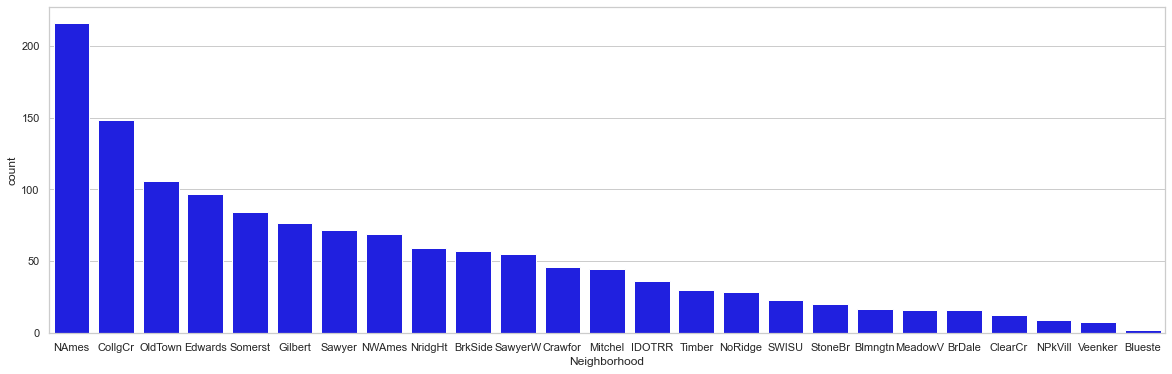

In [64]:
fig,ax=plt.subplots(1,1,figsize=(20,6))
sns.countplot(df9['Neighborhood'],order=df9['Neighborhood'].value_counts().index,color='Blue',ax=ax);

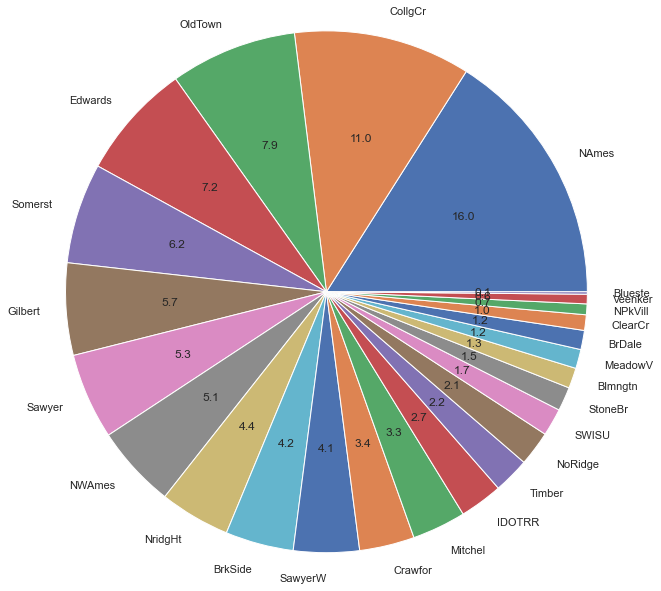

In [65]:
plt.pie(df9['Neighborhood'].value_counts(),labels=df9['Neighborhood'].value_counts().index,radius=3,autopct='%0.1f');

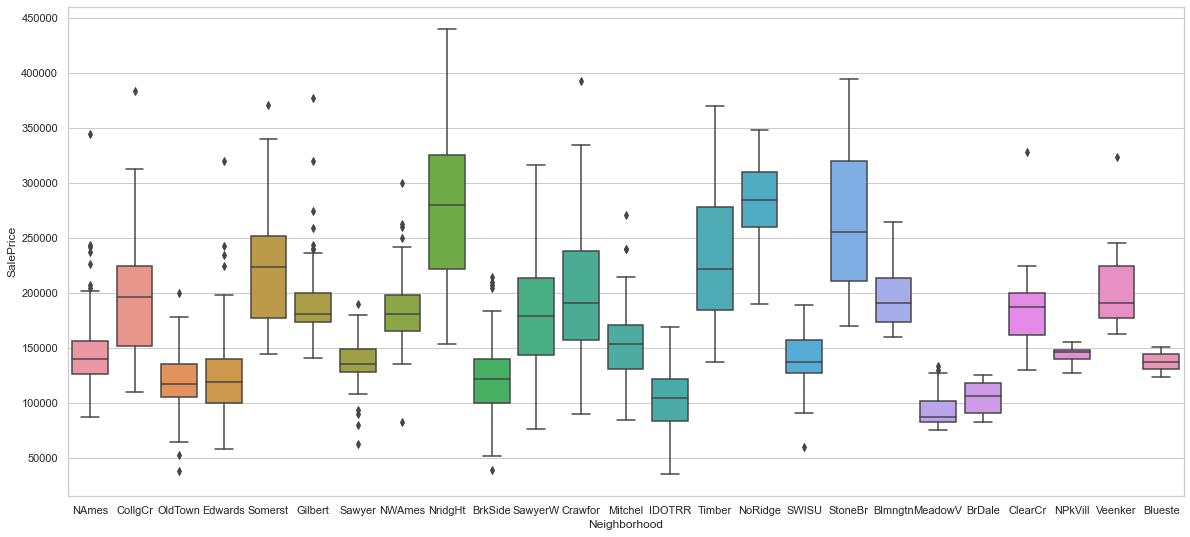

In [66]:
fig,ax=plt.subplots(1,1,figsize=(20,9))
sns.boxplot(data=df9,y='SalePrice',x='Neighborhood',ax=ax,order=df9['Neighborhood'].value_counts().index);

MSZoning      C (all)  FV  RH   RL  RM
Neighborhood                          
Blmngtn             0   0   0   16   1
Blueste             0   0   0    0   2
BrDale              0   0   0    0  16
BrkSide             0   0   0   27  30
ClearCr             0   0   0   13   0
CollgCr             0   0   0  138  10
Crawfor             0   0   2   41   3
Edwards             0   0   2   87   8
Gilbert             0   0   0   77   0
IDOTRR              8   0   0    0  28
MeadowV             0   0   0    0  16
Mitchel             0   0   0   40   5
NAmes               0   0   2  214   0
NPkVill             0   0   0    9   0
NWAmes              0   0   0   69   0
NoRidge             0   0   0   29   0
NridgHt             0   0   0   58   1
OldTown             1   0   0   17  88
SWISU               0   0   4   19   0
Sawyer              0   0   0   70   2
SawyerW             0   0   5   50   0
Somerst             0  64   0   20   0
StoneBr             0   0   0   20   0
Timber              0   0

<Figure size 864x576 with 0 Axes>

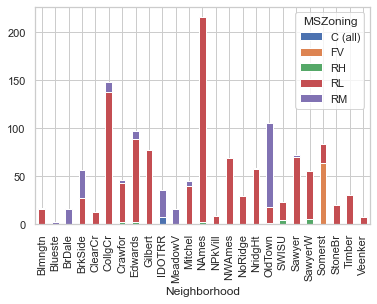

In [67]:
cont_table=pd.crosstab(index=df9['Neighborhood'],columns=df9['MSZoning'])
print (cont_table)
plt.figure(figsize=(12,8))
cont_table.plot(kind='bar',stacked=True);

**Answer**<br>
•	Neighborhoods [NridgHt and StoneBr and NoRidge] have high range of SalePrice and the rest of neighborhoods share the same range.<br>
•	MSZoning:
-	RL in all neighborhood<br>
-	FV only in Somerst<br>
-	RM mainly in BrDale,BrkSide,IDOTRR,MeadowVm,OldTown<br>


### Q4

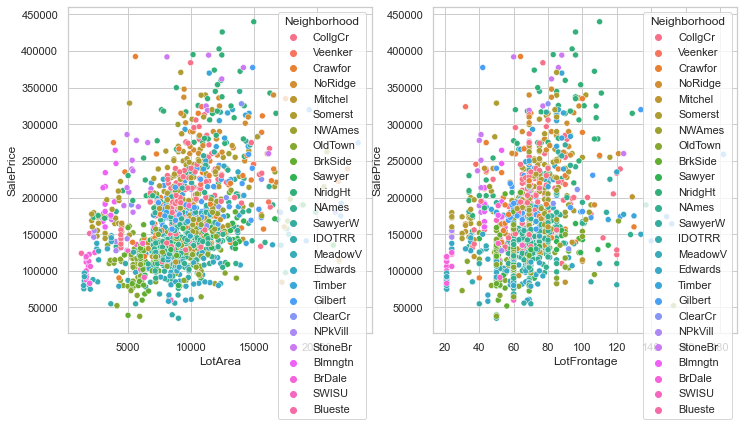

In [68]:
fig,a=plt.subplots(1,2,figsize=(12,6))
sns.scatterplot(data=df10,x='LotArea',y='SalePrice',ax=a[0],hue='Neighborhood');
sns.scatterplot(data=df10,x='LotFrontage',y='SalePrice',ax=a[1],hue='Neighborhood');

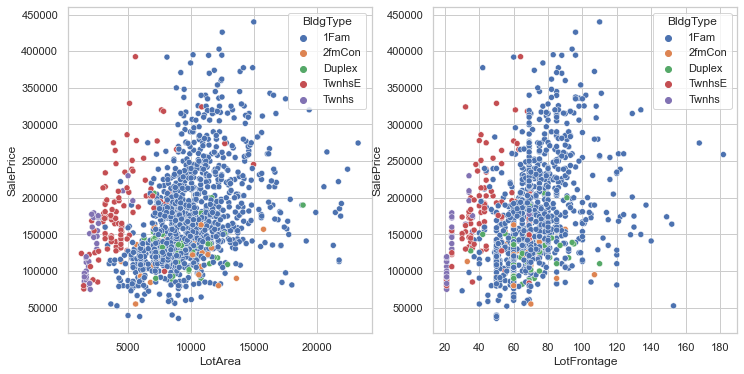

In [69]:
fig,a=plt.subplots(1,2,figsize=(12,6))
sns.scatterplot(data=df10,x='LotArea',y='SalePrice',ax=a[0],hue='BldgType');
sns.scatterplot(data=df10,x='LotFrontage',y='SalePrice',ax=a[1],hue='BldgType');

**Answer**<br>
•	In general, there is no correlation between LotArea, LotFrontage and SalePrice even if we show variations in Neighborhood or MSZoning

### Q5

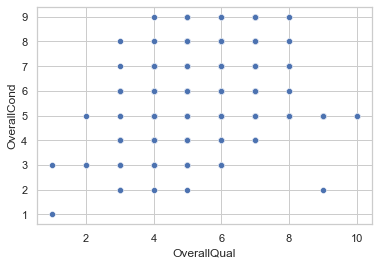

In [70]:
sns.scatterplot(data=df10,x='OverallQual',y='OverallCond');

**Answer**<br>
•	There is not relation between OverallQual and OverallCond

### Q7

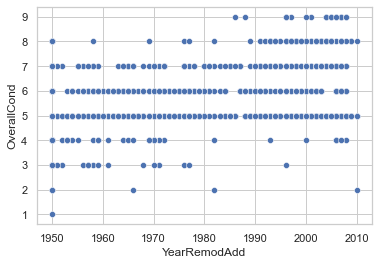

In [140]:
sns.scatterplot(data=df10,x='YearRemodAdd',y='OverallCond');

**Answer**<br>
from heatmap and our analysis before we can notice the following:

•	In 53% of data, YearBuilt and YearRemodAdd are the same which is not logic, may be it’s used to describe the last time the property was built/renewed <br>
•	Remod period ranges from 20 to 100 years


### Q8

**Answer**<br>
from heatmap and our analysis before we can notice the following:

•	There is positive correlation between YearRemodAdd and SalePrice<br>
•	I think YearRemodAdd will be more representative for SalePrice than YearBuilt I will drop the following columns: YearBuilt / GarageYrBlt since they don't add any new value to our dataset<br>
•	Positive correlation with high width between YearBuilt and SalePrice<br>
•	Alarm: in 53% of data, YearBuilt and YearRemodAdd are the same which is not logic, may be it’s used to describe the last time the property was built/renewed<br>
•	In 60% of data, GarageYearBlt is the same as property yearbuilt which is logic. However, there are 17 observations where garage was built before property<br>

### Q9

<AxesSubplot:xlabel='BsmtFinSF1'>

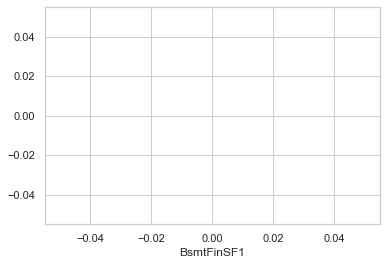

In [71]:
#Examining Bsmt Features
sns.scatterplot(data=df10,x='BsmtFinSF1')

**Answer**<br>
* There is a noticeable positive correlation between TotalBsmtSF and 1stFlrSF and SalePrice

### Q10

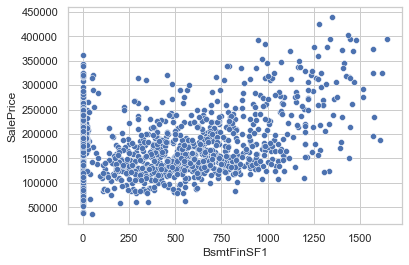

In [72]:
sns.scatterplot(df10['BsmtFinSF1'],df10['SalePrice']);

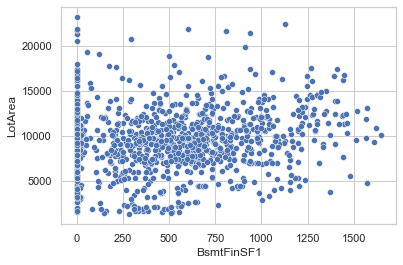

In [73]:
sns.scatterplot(df10['BsmtFinSF1'],df10['LotArea']);

**Answer**<br>
•	There is positive correlation between BsmtFinSF1 and SalePrice and no correlation to LotArea

### Q11

<AxesSubplot:xlabel='MoSold', ylabel='count'>

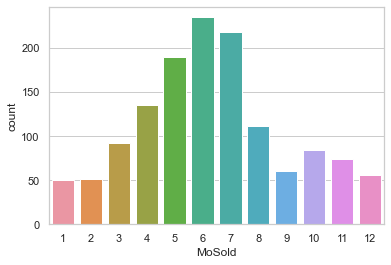

In [161]:
sns.countplot(df10['MoSold'])

**Answer**<br>
•	Most of sales are done in 2nd and 3rd quarter of the year

### Q12

<AxesSubplot:xlabel='SaleType', ylabel='SalePrice'>

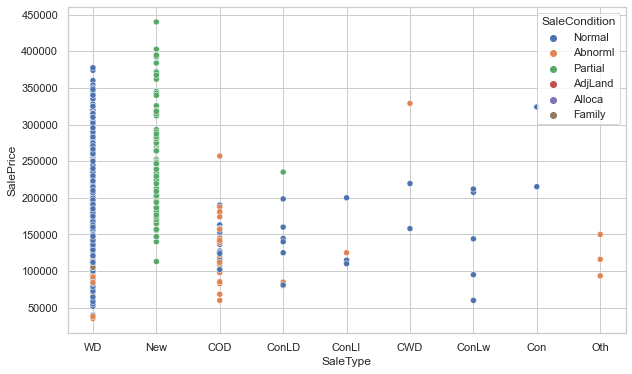

In [284]:
plt.figure(figsize=(10,6))
sns.scatterplot(df10['SaleType'],df10['SalePrice'],hue=df10['SaleCondition'])

**Answer**<br>
•	It’s important for our model I think

### Q13

**Answer**<br>
•	no obvious relation

### Q14

**Answer**<br>
•	Only Salecondition: new are sold partially 

### Q15

<AxesSubplot:xlabel='HeatingQC', ylabel='SalePrice'>

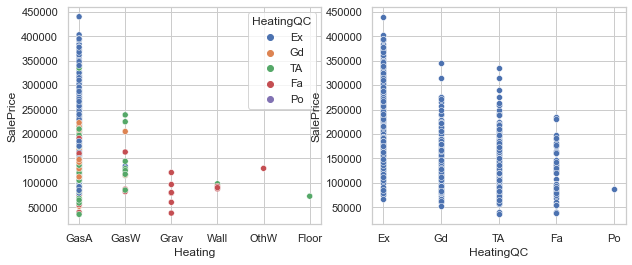

In [196]:
fig,a = plt.subplots(1,2,figsize=(10,4))
sns.scatterplot(data=df10,x='Heating',y='SalePrice',ax=a[0],hue='HeatingQC')
sns.scatterplot(data=df10,x='HeatingQC',y='SalePrice',ax=a[1])

<AxesSubplot:xlabel='CentralAir', ylabel='SalePrice'>

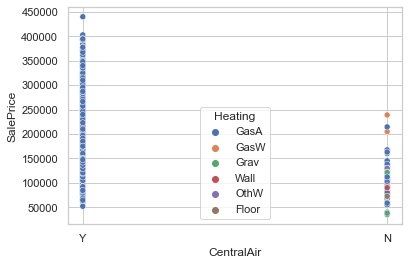

In [204]:
sns.scatterplot(data=df10,x='CentralAir',y='SalePrice',hue='Heating')

<AxesSubplot:xlabel='Electrical', ylabel='SalePrice'>

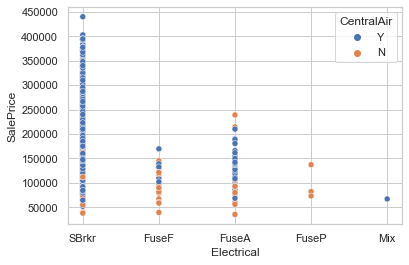

In [208]:
sns.scatterplot(data=df10,x='Electrical',y='SalePrice',hue='CentralAir')

**Answer**<br>
•	Heating & HeatingQC: other than GasA, you have a very limited options in saleprice <br>
•	CentralAir: if property doesn’t have centralAir, it will not have GasA heating and it’s price will drop dramatically<br>
•	Electrical: Saleprice will drop if electrical system is other than SBrkr<br>


### Q16

**Answer**<br>
* Well, I couldn't

# Machine learning

In [74]:
df10.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearRemodAdd',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'SaleType',
       'SaleCondition', 'SalePrice'],
      dtype='object')

In [75]:
list_num=m_describe.num(df10)
list_cat=m_describe.cat(df10)

In [76]:
list_num

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'MoSold',
 'SalePrice']

In [77]:
#changing the target variable column [MEDV] to be the first column
col_raw_ordered = ['SalePrice','MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'MasVnrArea',
 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'MoSold',]
df11_num = df10[col_raw_ordered]
df11_cat = df10[cat_list]

In [78]:
#Starting with numerical values

## Modeling raw data

In [81]:
y_raw = df11_num[col_raw_ordered[0:1]]
x_raw = df11_num[col_raw_ordered[1:]]

In [82]:
x_raw_tr,x_raw_ts, y_raw_tr,y_raw_ts = train_test_split(x_raw,y_raw,train_size=0.9)

In [83]:
m_mlinear_regression(x_raw_tr,x_raw_ts,y_raw_tr,y_raw_ts)

index             Model     Type Scaled     Score
0      12  GradientBoosting      500     No  0.902432
1      23     Random forest      500    Yes  0.893437
2      10     Random forest      500     No  0.891533
3      21     Random forest      300    Yes  0.891109
4       9     Random forest      400     No  0.890923
5       7     Random forest      200     No  0.889693
6       6     Random forest      100     No  0.888806
7      22     Random forest      400    Yes  0.888531
8      20     Random forest      200    Yes  0.888022
9       8     Random forest      300     No  0.887878
10     19     Random forest      100    Yes  0.887338
11     13            Linear  General    Yes  0.878505
12      0            Linear  General     No  0.878505
13     11           XGBoost      500     No  0.869463
14     24           XGBoost      500    Yes  0.869294
15      2               SVR   linear     No  0.827006
16     18     Decision tree  General    Yes  0.707237
17      5     Decision tree  General     No  0.699308
18     15               SVR   linear    Yes  0.138306
19     17               SVR  sigmoid    Yes -0.015275
20      3               SVR     poly     No -0.016327
21     16               SVR     poly    Yes -0.019008
22     14               SVR      rbf    Yes -0.019509
23      1               SVR      rbf     No -0.021247
24      4               SVR  sigmoid     No -0.021660

Without any feature engineering yet and modelling only numerical values, we created a model with an accuracy of >80%. 

Best models so far are Random forest (scaled) / GradientBoosting / Linear / XGBoost

## Feature engineering

### Filtering

#### Constant / Quasi constant features

In [84]:
#checking constant variables
selector_const = VarianceThreshold(threshold=0.0)
selector_const.fit(x_raw_tr)

VarianceThreshold()

In [85]:
selector_const.get_support().sum(), x_raw_tr.shape[1]

(25, 25)

There are no constant features

In [86]:
#checking quasi constant variables
selector_quasi = VarianceThreshold(threshold=0.01)
selector_quasi.fit(x_raw_tr)

VarianceThreshold(threshold=0.01)

In [87]:
selector_quasi.get_support().sum(), x_raw_tr.shape[1]

(25, 25)

There are no semi constant features

In [88]:
#creating features and variance list
features_variance = {'feature':list(x_raw_tr.columns),'feature_variance':list(selector_quasi.get_support())}
df_features_variance = pd.DataFrame(features_variance)
df_features_variance[(df_features_variance['feature_variance']==False)]

Empty DataFrame
Columns: [feature, feature_variance]
Index: []

#### Correlation

In [89]:
m_correlation(x_raw_tr,0.8)

['GarageArea', 'TotRmsAbvGrd']

There is  not a heavy correlation between ['TotRmsAbvGrd', 'GarageArea']

<AxesSubplot:xlabel='TotRmsAbvGrd', ylabel='GarageArea'>

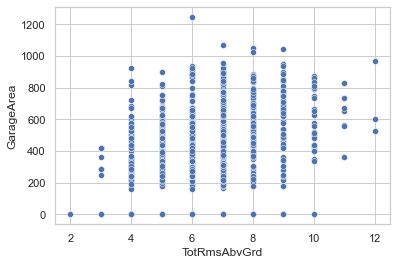

In [90]:
sns.scatterplot(df10['TotRmsAbvGrd'],df10['GarageArea'])

In [91]:
m_VIF(x_raw_tr,y_raw_tr)

SyntaxError: invalid syntax (<unknown>, line 1)

### Wrapping

### Embedded

#### Feature importance

features  importance
3    OverallQual    0.593498
13     GrLivArea    0.103954
7     BsmtFinSF1    0.051249
10   TotalBsmtSF    0.050500
21    GarageArea    0.036426
20    GarageCars    0.023829
5   YearRemodAdd    0.022984
11      1stFlrSF    0.017105
2        LotArea    0.016082
4    OverallCond    0.009390
1    LotFrontage    0.009105
9      BsmtUnfSF    0.008239
23   OpenPorchSF    0.008232
12      2ndFlrSF    0.007807
6     MasVnrArea    0.007026
15      FullBath    0.007017
24        MoSold    0.005355
22    WoodDeckSF    0.004828
0     MSSubClass    0.004621
19    Fireplaces    0.004207
18  TotRmsAbvGrd    0.003039
14  BsmtFullBath    0.001894
17  BedroomAbvGr    0.001526
16      HalfBath    0.001526
8     BsmtFinSF2    0.000564

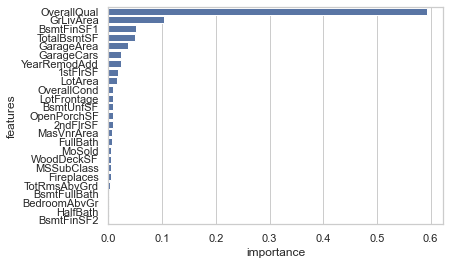

In [92]:
m_feature_importance(x_raw_tr,y_raw_tr,100)

In [93]:
# let's drop the following columns and check the model
df12=df11_num.copy()
drop_list= ['GarageArea','BsmtFinSF2','BsmtFullBath','HalfBath','BedroomAbvGr','FullBath','WoodDeckSF','MoSold']
df12.drop(labels=drop_list,axis=1,inplace=True)
col_12=list(df12.columns)

In [94]:
y_12 = df12[col_12[0:1]]
x_12 = df12[col_12[1:]]

In [95]:
x_12_tr,x_12_ts, y_12_tr,y_12_ts = train_test_split(x_12,y_12,train_size=0.9)

In [96]:
m_mlinear_regression(x_12_tr,x_12_ts,y_12_tr,y_12_ts)

index             Model     Type Scaled     Score
0      12  GradientBoosting      500     No  0.855188
1      11           XGBoost      500     No  0.829923
2      24           XGBoost      500    Yes  0.829861
3      20     Random forest      200    Yes  0.828376
4       9     Random forest      400     No  0.827057
5      19     Random forest      100    Yes  0.826137
6      10     Random forest      500     No  0.825910
7      22     Random forest      400    Yes  0.823819
8       7     Random forest      200     No  0.823366
9      21     Random forest      300    Yes  0.822218
10      8     Random forest      300     No  0.821454
11     23     Random forest      500    Yes  0.820810
12      6     Random forest      100     No  0.820345
13      0            Linear  General     No  0.804493
14     13            Linear  General    Yes  0.804493
15      2               SVR   linear     No  0.750263
16     18     Decision tree  General    Yes  0.736065
17      5     Decision tree  General     No  0.727493
18     15               SVR   linear    Yes  0.052501
19      3               SVR     poly     No -0.056864
20     17               SVR  sigmoid    Yes -0.062723
21     16               SVR     poly    Yes -0.064337
22     14               SVR      rbf    Yes -0.067486
23      1               SVR      rbf     No -0.068367
24      4               SVR  sigmoid     No -0.069442

our models didn't perfrom worse and didn't improve very much, let's drop more features 

features  importance
3    OverallQual    0.603452
12     GrLivArea    0.120890
7     BsmtFinSF1    0.063655
9    TotalBsmtSF    0.052792
5   YearRemodAdd    0.026932
15    GarageCars    0.026667
2        LotArea    0.019411
10      1stFlrSF    0.018058
1    LotFrontage    0.012134
8      BsmtUnfSF    0.010128
4    OverallCond    0.010096
16   OpenPorchSF    0.008560
6     MasVnrArea    0.007439
11      2ndFlrSF    0.007043
14    Fireplaces    0.005129
0     MSSubClass    0.004794
13  TotRmsAbvGrd    0.002821

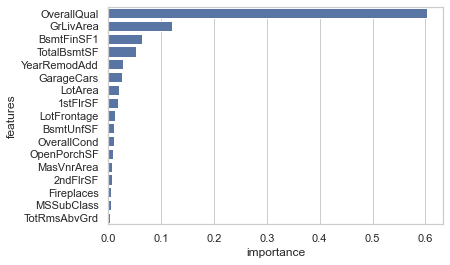

In [336]:
m_feature_importance(x_12_tr,y_12_tr,100)

Let's try dropping features ['TotRmsAbvGrd','MSSubClass','Fireplaces','2ndFlrSF','MasVnrArea','OpenPorchSF']

In [109]:
# let's drop the following columns and check the model
df13=df12.copy()
drop_list= ['TotRmsAbvGrd','MSSubClass','Fireplaces','2ndFlrSF','MasVnrArea','OpenPorchSF']
df13.drop(labels=drop_list,axis=1,inplace=True)
col_13=list(df13.columns)

In [110]:
y_13 = df13[col_13[0:1]]
x_13 = df13[col_13[1:]]

In [111]:
x_13_tr,x_13_ts, y_13_tr,y_13_ts = train_test_split(x_13,y_13,train_size=0.9)

In [112]:
m_mlinear_regression(x_13_tr,x_13_ts,y_13_tr,y_13_ts)

index             Model     Type Scaled     Score
0      12  GradientBoosting      500     No  0.900764
1       6     Random forest      100     No  0.899507
2      19     Random forest      100    Yes  0.898567
3      22     Random forest      400    Yes  0.898156
4      21     Random forest      300    Yes  0.898126
5       9     Random forest      400     No  0.897912
6      10     Random forest      500     No  0.897076
7      20     Random forest      200    Yes  0.896969
8       8     Random forest      300     No  0.896817
9      23     Random forest      500    Yes  0.896727
10      7     Random forest      200     No  0.896381
11     11           XGBoost      500     No  0.884948
12     24           XGBoost      500    Yes  0.884916
13      0            Linear  General     No  0.880498
14     13            Linear  General    Yes  0.880498
15      2               SVR   linear     No  0.777130
16     18     Decision tree  General    Yes  0.773413
17      5     Decision tree  General     No  0.773084
18     15               SVR   linear    Yes  0.058699
19     16               SVR     poly    Yes -0.024337
20      3               SVR     poly     No -0.025856
21     17               SVR  sigmoid    Yes -0.026622
22     14               SVR      rbf    Yes -0.031286
23      1               SVR      rbf     No -0.032721
24      4               SVR  sigmoid     No -0.033067

our models didn't perfrom worse and didn't improve very much, let's drop more features : ['OverallCond','BsmtUnfSF','LotFrontage','1stFlrSF']

In [113]:
# let's drop the following columns and check the model
df14=df13.copy()
drop_list= ['OverallCond','BsmtUnfSF','LotFrontage','1stFlrSF']
df14.drop(labels=drop_list,axis=1,inplace=True)
col_14=list(df14.columns)

In [114]:
y_14 = df14[col_14[0:1]]
x_14 = df14[col_14[1:]]
x_14.head(2)

LotArea  OverallQual  YearRemodAdd  BsmtFinSF1  TotalBsmtSF  GrLivArea  \
0     8450            7          2003         706          856       1710   
1     9600            6          1976         978         1262       1262   

   GarageCars  
0           2  
1           2

In [115]:
x_14_tr,x_14_ts, y_14_tr,y_14_ts = train_test_split(x_14,y_14,train_size=0.9)

In [116]:
m_mlinear_regression(x_14_tr,x_14_ts,y_14_tr,y_14_ts)

index             Model     Type Scaled     Score
0       8     Random forest      300     No  0.865158
1      23     Random forest      500    Yes  0.864834
2       7     Random forest      200     No  0.863494
3      19     Random forest      100    Yes  0.862940
4      12  GradientBoosting      500     No  0.862879
5      10     Random forest      500     No  0.862679
6      22     Random forest      400    Yes  0.862280
7       9     Random forest      400     No  0.861905
8      21     Random forest      300    Yes  0.861078
9       6     Random forest      100     No  0.859666
10     20     Random forest      200    Yes  0.857477
11     24           XGBoost      500    Yes  0.842095
12     11           XGBoost      500     No  0.842057
13      0            Linear  General     No  0.833490
14     13            Linear  General    Yes  0.833490
15      2               SVR   linear     No  0.712274
16     18     Decision tree  General    Yes  0.683998
17      5     Decision tree  General     No  0.676579
18     15               SVR   linear    Yes  0.004919
19     16               SVR     poly    Yes -0.055906
20      3               SVR     poly     No -0.059716
21     17               SVR  sigmoid    Yes -0.064312
22     14               SVR      rbf    Yes -0.071412
23      1               SVR      rbf     No -0.073059
24      4               SVR  sigmoid     No -0.074296

so far our model isn't performing worse by removing features and making it more simple

features  importance
1   OverallQual    0.614199
5     GrLivArea    0.130794
4   TotalBsmtSF    0.080351
3    BsmtFinSF1    0.063637
2  YearRemodAdd    0.040657
0       LotArea    0.037097
6    GarageCars    0.033265

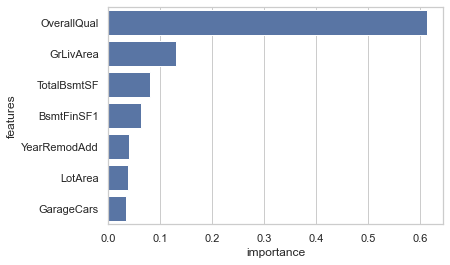

In [117]:
m_feature_importance(x_14_tr,y_14_tr,100)

In [118]:
# let's drop the following columns and check the model
df15=df14.copy()
drop_list= ['BsmtFinSF1','GarageCars']
df15.drop(labels=drop_list,axis=1,inplace=True)
col_15=list(df15.columns)

In [119]:
y_15 = df14[col_15[0:1]]
x_15 = df14[col_15[1:]]
x_15.head(2)

LotArea  OverallQual  YearRemodAdd  TotalBsmtSF  GrLivArea
0     8450            7          2003          856       1710
1     9600            6          1976         1262       1262

In [120]:
x_15_tr,x_15_ts, y_15_tr,y_15_ts = train_test_split(x_15,y_15,train_size=0.9)

In [121]:
m_mlinear_regression(x_15_tr,x_15_ts,y_15_tr,y_15_ts)

index             Model     Type Scaled     Score
0      10     Random forest      500     No  0.903119
1      22     Random forest      400    Yes  0.901671
2      23     Random forest      500    Yes  0.901059
3       8     Random forest      300     No  0.900711
4      21     Random forest      300    Yes  0.900632
5      20     Random forest      200    Yes  0.900537
6       7     Random forest      200     No  0.899549
7       9     Random forest      400     No  0.899417
8      12  GradientBoosting      500     No  0.898244
9       6     Random forest      100     No  0.897216
10     19     Random forest      100    Yes  0.896225
11     11           XGBoost      500     No  0.864287
12     13            Linear  General    Yes  0.864220
13      0            Linear  General     No  0.864220
14     24           XGBoost      500    Yes  0.863827
15     18     Decision tree  General    Yes  0.804277
16      5     Decision tree  General     No  0.797608
17      2               SVR   linear     No  0.765371
18     15               SVR   linear    Yes -0.053179
19     16               SVR     poly    Yes -0.100683
20      3               SVR     poly     No -0.106841
21     17               SVR  sigmoid    Yes -0.113306
22     14               SVR      rbf    Yes -0.121019
23      1               SVR      rbf     No -0.122994
24      4               SVR  sigmoid     No -0.124439

the model started to perform worse, so I will neglect the last change and start to improve it by adding categorical variables

#### Dimensionality reduction

In [122]:
#i tried with differet n_components but it didn't improve my model
pca =PCA(n_components=5).fit(x_raw_tr)
x_pca_tr=pca.transform(x_raw_tr)
x_pca_ts=pca.transform(x_raw_ts)
m_mlinear_regression(x_pca_tr,x_pca_ts,y_raw_tr,y_raw_ts)

index             Model     Type Scaled     Score
0      12  GradientBoosting      500     No  0.780768
1      19     Random forest      100    Yes  0.771952
2      22     Random forest      400    Yes  0.761053
3       8     Random forest      300     No  0.759499
4      23     Random forest      500    Yes  0.758470
5       9     Random forest      400     No  0.758236
6       7     Random forest      200     No  0.758188
7      21     Random forest      300    Yes  0.756034
8      10     Random forest      500     No  0.755593
9      20     Random forest      200    Yes  0.751808
10     11           XGBoost      500     No  0.746493
11     24           XGBoost      500    Yes  0.746493
12      6     Random forest      100     No  0.743414
13      0            Linear  General     No  0.710513
14     13            Linear  General    Yes  0.710513
15      2               SVR   linear     No  0.702248
16     18     Decision tree  General    Yes  0.507148
17      5     Decision tree  General     No  0.494842
18      3               SVR     poly     No -0.000139
19     15               SVR   linear    Yes -0.000242
20     16               SVR     poly    Yes -0.017568
21     17               SVR  sigmoid    Yes -0.017613
22     14               SVR      rbf    Yes -0.019767
23      4               SVR  sigmoid     No -0.019847
24      1               SVR      rbf     No -0.020681

In [123]:
lda = LinearDiscriminantAnalysis()
lda.fit_transform(x_raw_tr,y_raw_tr)
x_lda_tr=lda.transform(x_raw_tr)
x_lda_ts=lda.transform(x_raw_ts)
m_mlinear_regression(x_lda_tr,x_lda_ts,y_raw_tr,y_raw_ts)

index             Model     Type Scaled     Score
0      24           XGBoost      500    Yes  0.909980
1      11           XGBoost      500     No  0.909980
2      20     Random forest      200    Yes  0.901626
3       6     Random forest      100     No  0.901198
4      23     Random forest      500    Yes  0.900538
5       8     Random forest      300     No  0.900257
6      19     Random forest      100    Yes  0.899189
7      10     Random forest      500     No  0.898668
8       9     Random forest      400     No  0.898219
9      22     Random forest      400    Yes  0.898023
10     21     Random forest      300    Yes  0.896624
11      7     Random forest      200     No  0.895493
12     12  GradientBoosting      500     No  0.892298
13     13            Linear  General    Yes  0.878505
14      0            Linear  General     No  0.878505
15     18     Decision tree  General    Yes  0.794361
16      5     Decision tree  General     No  0.763956
17      2               SVR   linear     No  0.224913
18     15               SVR   linear    Yes  0.009137
19      4               SVR  sigmoid     No -0.014029
20      3               SVR     poly     No -0.018283
21      1               SVR      rbf     No -0.019290
22     17               SVR  sigmoid    Yes -0.020399
23     14               SVR      rbf    Yes -0.021029
24     16               SVR     poly    Yes -0.021490

Let's try to add some important categorical features and see if it improves our model

In [125]:
cat_features=['MSZoning','LotShape','LandContour','LotConfig','LandSlope','Neighborhood','Condition1','BldgType','HouseStyle',
'RoofStyle','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure',
'BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType',
'GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition']

for feat in list_cat:
    col = list(df14.columns)
    col.append(feat)

    df16 = df10[col]

    dum_df = pd.get_dummies(df16[feat],drop_first=True)
    df16_dum = pd.concat([df16,dum_df],axis=1)
    df16_dum=df16_dum.drop(labels=[feat],axis=1)
    col_16= list(df16_dum.columns)
    y_16=df16_dum[col_16[0:1]]
    x_16=df16_dum[col_16[1:]]
    x_16_tr,x_16_ts,y_16_tr,y_16_ts=train_test_split(x_16,y_16,train_size=0.9)
    print ('')
    print (feat)
    print (m_mlinear_regression(x_16_tr,x_16_ts,y_16_tr,y_16_ts))


MSZoning
    index             Model     Type Scaled     Score
0      12  GradientBoosting      500     No  0.906894
1      19     Random forest      100    Yes  0.904173
2       9     Random forest      400     No  0.903847
3      22     Random forest      400    Yes  0.903111
4      23     Random forest      500    Yes  0.902808
5      10     Random forest      500     No  0.902224
6      21     Random forest      300    Yes  0.901670
7       8     Random forest      300     No  0.900937
8      20     Random forest      200    Yes  0.900689
9       7     Random forest      200     No  0.898641
10      6     Random forest      100     No  0.895859
11     24           XGBoost      500    Yes  0.879593
12     11           XGBoost      500     No  0.879066
13     13            Linear  General    Yes  0.862381
14      0            Linear  General     No  0.862381
15      2               SVR   linear     No  0.769801
16      5     Decision tree  General     No  0.764069
17     18     Deci

    index             Model     Type Scaled     Score
0      12  GradientBoosting      500     No  0.877613
1      10     Random forest      500     No  0.872507
2       8     Random forest      300     No  0.871525
3      22     Random forest      400    Yes  0.871381
4       7     Random forest      200     No  0.871185
5       9     Random forest      400     No  0.871105
6      23     Random forest      500    Yes  0.870813
7      21     Random forest      300    Yes  0.870607
8      20     Random forest      200    Yes  0.870299
9       6     Random forest      100     No  0.869834
10     19     Random forest      100    Yes  0.868633
11     11           XGBoost      500     No  0.856586
12     24           XGBoost      500    Yes  0.856356
13     13            Linear  General    Yes  0.839798
14      0            Linear  General     No  0.839798
15      2               SVR   linear     No  0.743629
16     18     Decision tree  General    Yes  0.713406
17      5     Decision tree 

    index             Model     Type Scaled     Score
0      20     Random forest      200    Yes  0.878051
1       7     Random forest      200     No  0.877963
2       8     Random forest      300     No  0.877948
3      21     Random forest      300    Yes  0.877863
4       9     Random forest      400     No  0.877689
5      10     Random forest      500     No  0.876366
6       6     Random forest      100     No  0.876262
7      23     Random forest      500    Yes  0.876084
8      22     Random forest      400    Yes  0.875747
9      19     Random forest      100    Yes  0.874459
10     12  GradientBoosting      500     No  0.855375
11     11           XGBoost      500     No  0.843130
12     24           XGBoost      500    Yes  0.843012
13     18     Decision tree  General    Yes  0.825496
14     13            Linear  General    Yes  0.823654
15      0            Linear  General     No  0.823654
16      5     Decision tree  General     No  0.810839
17      2               SVR 

    index             Model     Type Scaled     Score
0      12  GradientBoosting      500     No  0.902980
1      10     Random forest      500     No  0.897319
2       7     Random forest      200     No  0.897043
3      20     Random forest      200    Yes  0.896181
4      23     Random forest      500    Yes  0.896113
5       8     Random forest      300     No  0.896111
6      22     Random forest      400    Yes  0.895909
7      19     Random forest      100    Yes  0.895754
8      21     Random forest      300    Yes  0.894304
9       9     Random forest      400     No  0.893801
10     13            Linear  General    Yes  0.892651
11      0            Linear  General     No  0.892651
12      6     Random forest      100     No  0.889897
13     24           XGBoost      500    Yes  0.863054
14     11           XGBoost      500     No  0.862879
15      2               SVR   linear     No  0.802051
16     18     Decision tree  General    Yes  0.739442
17      5     Decision tree 

    index             Model     Type Scaled     Score
0      12  GradientBoosting      500     No  0.887560
1       6     Random forest      100     No  0.885208
2      10     Random forest      500     No  0.885087
3      21     Random forest      300    Yes  0.883547
4       7     Random forest      200     No  0.883444
5       8     Random forest      300     No  0.882110
6      19     Random forest      100    Yes  0.881497
7      20     Random forest      200    Yes  0.881156
8      22     Random forest      400    Yes  0.880920
9      23     Random forest      500    Yes  0.880101
10      9     Random forest      400     No  0.879318
11     24           XGBoost      500    Yes  0.862897
12     11           XGBoost      500     No  0.862077
13      0            Linear  General     No  0.855961
14     13            Linear  General    Yes  0.855961
15      2               SVR   linear     No  0.809236
16      5     Decision tree  General     No  0.751300
17     18     Decision tree 

    index             Model     Type Scaled     Score
0       9     Random forest      400     No  0.917464
1      22     Random forest      400    Yes  0.916756
2      21     Random forest      300    Yes  0.916034
3      10     Random forest      500     No  0.914709
4      23     Random forest      500    Yes  0.914616
5       7     Random forest      200     No  0.914537
6       8     Random forest      300     No  0.913077
7      20     Random forest      200    Yes  0.912646
8      19     Random forest      100    Yes  0.911843
9       6     Random forest      100     No  0.910702
10     24           XGBoost      500    Yes  0.897989
11     11           XGBoost      500     No  0.897873
12     12  GradientBoosting      500     No  0.890377
13     13            Linear  General    Yes  0.879527
14      0            Linear  General     No  0.879527
15      2               SVR   linear     No  0.818277
16     18     Decision tree  General    Yes  0.788855
17      5     Decision tree 

After looping through 34 different categorical features, the following features may be relevant:
* LotShape -90%
* LotConfig -90%
* LandSlope -90%
* Condition1 -90%
* HouseStyle -90%
* CentralAir -90%
* GarageQual -90%
* SaleType -90%
* SaleCondition -93%

Let's construct a model containing those features

In [126]:
feat_selected=['SaleCondition','CentralAir']
num_col_selected=list(df14.columns)
col_selected = feat_selected+num_col_selected

In [130]:
df16=df10[col_selected]

In [132]:
df16_dum=pd.get_dummies(df16,drop_first=True)

In [133]:
col_16= list(df16_dum.columns)
y_16=df16_dum[col_16[0:1]]
x_16=df16_dum[col_16[1:]]
x_16_tr,x_16_ts,y_16_tr,y_16_ts=train_test_split(x_16,y_16,train_size=0.9)
m_mlinear_regression(x_16_tr,x_16_ts,y_16_tr,y_16_ts)

index             Model     Type Scaled     Score
0       7     Random forest      200     No  0.874724
1       6     Random forest      100     No  0.874039
2      23     Random forest      500    Yes  0.871837
3      20     Random forest      200    Yes  0.870894
4      22     Random forest      400    Yes  0.870174
5       9     Random forest      400     No  0.869217
6      21     Random forest      300    Yes  0.869215
7      10     Random forest      500     No  0.868835
8      19     Random forest      100    Yes  0.868001
9       8     Random forest      300     No  0.867172
10     12  GradientBoosting      500     No  0.861157
11     24           XGBoost      500    Yes  0.847065
12     11           XGBoost      500     No  0.846708
13     13            Linear  General    Yes  0.845372
14      0            Linear  General     No  0.845372
15     18     Decision tree  General    Yes  0.770686
16      5     Decision tree  General     No  0.724293
17      2               SVR   linear     No  0.696053
18     15               SVR   linear    Yes  0.052488
19     16               SVR     poly    Yes -0.021600
20      3               SVR     poly     No -0.025731
21     17               SVR  sigmoid    Yes -0.028781
22     14               SVR      rbf    Yes -0.032657
23      1               SVR      rbf     No -0.034487
24      4               SVR  sigmoid     No -0.035184

mmmm, not big improvement yet

## Evaluation models

### K fold with random forest

In [135]:
sc = StandardScaler()
xtr_sc = sc.fit_transform(x_16_tr)
xts_sc = sc.transform(x_16_ts)

In [136]:
model_1 = RandomForestRegressor(n_estimators=100)
model_2 = GradientBoostingRegressor()

In [137]:
cv = cross_val_score(estimator=model_1,X=xtr_sc,y=y_16_tr,cv=10)

In [138]:
cv.mean(),cv.std(),cv.max()

(0.8663919151553108, 0.03069149896392418, 0.9153664902236791)

In [139]:
cv = cross_val_score(estimator=model_2,X=xtr_sc,y=y_16_tr,cv=10)

In [140]:
cv.mean(),cv.std(),cv.max()

(0.8808518587877412, 0.023072393400485343, 0.9249739413136858)

So my best model so far is GradientBoostingRegressor

## Optimizing hyperparameters

In [141]:
parameters = {'n_estimators':[100,200,300]}
gsearch = GridSearchCV(estimator=model_2,param_grid=parameters)

In [142]:
gsearch.fit(xtr_sc,y_16_tr).best_params_

{'n_estimators': 100}

our best model so far is random forest with n_estimators=100